Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

1. Import required libraries and load the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import shap

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display

# Load dataset
raw_data = pd.read_excel('./import/DataSet_V47.xlsx')

1.1. Select features

In [3]:
columns_in_data = ['Age', 
           'ОССН KiLLip', 
           'ЧСС (b)', 
           'Систолическое АД(b)', 
           'Креатинин', 
           'EF%',
           'Лейкоциты(b)',
           'Глюкоза(a)',
           'начало операции',
           'Дата операции в БД',
           'дата выписки',
           'дата смерти',
           'Исход заболевания']
data=raw_data.loc[(raw_data['STEMI']== 'Да')  & 
                   (raw_data['Наличие в БД']== 'Да')  & 
                  (raw_data['Наличие в файле']== 'Да') &
                   (raw_data['ЧКВ']== 'Да'),
                   columns_in_data]

In [4]:
display(data.shape)
display(data.describe())

(4681, 13)

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,4681.000000,4681.000000,4646.000000,4678.000000,4611.000000,4215.000000,3471.000000,4388.000000
mean,62.357830,1.678701,75.471481,133.127832,106.279991,54.638434,11.375367,6.681723
std,11.038623,0.980228,16.091129,25.197232,51.464548,8.914919,4.138540,3.124519
min,26.000000,0.000000,20.000000,15.000000,3.830000,10.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,81.530000,49.000000,8.500000,5.120000
50%,63.000000,1.000000,72.000000,130.000000,97.820000,56.000000,10.700000,5.830000
75%,70.000000,2.000000,81.000000,150.000000,116.630000,61.000000,13.500000,7.100000
max,93.000000,4.000000,200.000000,260.000000,1354.000000,80.000000,43.100000,77.330000


Removing rows with NaN values

In [5]:
print("Amount of NaN values in different columns before:")
display(data.isna().sum())

columns_to_check = ['Age',
                   'ЧСС (b)', 
                   'Систолическое АД(b)', 
                   'Креатинин',
                   'EF%', 
                   'Лейкоциты(b)',  
                   'Глюкоза(a)']
data_no_nan = data.dropna(subset=columns_to_check)
print("Amount of NaN values in different columns after:")
display(data_no_nan.isna().sum())

Amount of NaN values in different columns before:


Age                       0
ОССН KiLLip               0
ЧСС (b)                  35
Систолическое АД(b)       3
Креатинин                70
EF%                     466
Лейкоциты(b)           1210
Глюкоза(a)              293
начало операции        1549
Дата операции в БД        0
дата выписки           1580
дата смерти            4360
Исход заболевания         0
dtype: int64

Amount of NaN values in different columns after:


Age                       0
ОССН KiLLip               0
ЧСС (b)                   0
Систолическое АД(b)       0
Креатинин                 0
EF%                       0
Лейкоциты(b)              0
Глюкоза(a)                0
начало операции        1082
Дата операции в БД        0
дата выписки           1086
дата смерти            2920
Исход заболевания         0
dtype: int64

1.2. Explore how NaN values in 'дата выписки', 'дата смерти' are related to each other and to 'Исход заболевания'. 
Count records where both are NaN:

In [6]:

begin_end_op_and_death_dates_nan = data_no_nan.loc[
    data_no_nan['дата выписки'].isna() & 
    data_no_nan['дата смерти'].isna()]

display(begin_end_op_and_death_dates_nan.groupby('Исход заболевания').size())

Исход заболевания
без перемен                                     3
выписан с улучшением                            1
неоконченный случай с улучшением                1
переведен в другой стационар с улучшением       3
с выздоровлением                                1
с улучшением                                 1034
самоуход                                        1
dtype: int64

1.3. Examine dates and patients' conditons

In [7]:
data_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3027 entries, 18 to 12517
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Age                  3027 non-null   float64       
 1   ОССН KiLLip          3027 non-null   float64       
 2   ЧСС (b)              3027 non-null   float64       
 3   Систолическое АД(b)  3027 non-null   float64       
 4   Креатинин            3027 non-null   float64       
 5   EF%                  3027 non-null   float64       
 6   Лейкоциты(b)         3027 non-null   float64       
 7   Глюкоза(a)           3027 non-null   float64       
 8   начало операции      1945 non-null   datetime64[ns]
 9   Дата операции в БД   3027 non-null   datetime64[ns]
 10  дата выписки         1941 non-null   object        
 11  дата смерти          107 non-null    object        
 12  Исход заболевания    3027 non-null   object        
dtypes: datetime64[ns](2), float64(8

Parsing date-time columns into date-time format.

In [8]:
data_no_nan_copy = data_no_nan.copy()
for col_name in ['Дата операции в БД', 'дата выписки', 'дата смерти']:
    new_col_name = f"{col_name}_parsed"
    data_no_nan_copy[new_col_name] = pd.to_datetime(data_no_nan_copy[col_name], errors='coerce')

Now checking NaN 'дата смерти' and 'Исход заболевания' for any strange rows.

In [9]:
query_expression = "(not `дата смерти`.isnull() and `Исход заболевания` != 'умер')"
data_no_nan_copy.query(query_expression)


,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a),начало операции,Дата операции в БД,дата выписки,дата смерти,Исход заболевания,Дата операции в БД_parsed,дата выписки_parsed,дата смерти_parsed
9761,61.0,3.0,72.0,130.0,108.0,65.0,12.9,6.37,2016-12-29 15:00:00,2016-12-29,2017-01-02 18:51:00,2017-01-02 00:00:00,самоуход,2016-12-29,2017-01-02 18:51:00,2017-01-02


This row is ambiguous. Will drop it.

In [10]:
# Applying De Morgan's laws to the query
query_expression_2 = "(`дата смерти`.isnull() or `Исход заболевания` == 'умер')"
# Drop rows that satisfy the query expression
display(data_no_nan_copy.shape)
clean_data = data_no_nan_copy.query(query_expression_2)
display(clean_data.shape)

(3027, 16)

(3026, 16)

Keeping only death cases within 55 days from the operation date.

Note: If there is no information about "Дата смерти", but "Исход заболевания" is "умер", we will consider the date from "Дата выписки" as the day of death.

In [11]:
mask = (
    (clean_data['дата смерти_parsed'].notna()) & 
                (clean_data['дата смерти_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
    | ((clean_data['дата смерти_parsed'].isna()) & 
                (clean_data['Исход заболевания'] == 'умер') & 
                (clean_data['дата выписки_parsed'].notna()) & 
                (clean_data['дата выписки_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
        )
)

rows_to_keep = ~mask

In [12]:
print(f"Rows to drop: {clean_data[mask].shape[0]}")
ready_data = clean_data[rows_to_keep]
print(f"Rows left in the dataset: {ready_data.shape[0]}")

Rows to drop: 2
Rows left in the dataset: 3024


In [13]:
ready_data.describe()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000


2. Split the dataset into features and target.

In [14]:
X = ready_data[['Age', 
                        'ОССН KiLLip', 
                        'ЧСС (b)', 
                        'Систолическое АД(b)', 
                        'Креатинин', 
                        'EF%', 
                        'Лейкоциты(b)', 
                        'Глюкоза(a)']]
y = ready_data['Исход заболевания'].apply(lambda x: 1 if x == 'умер' else 0)

In [15]:
display(X.describe())

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000


2.1. Split features and target into train and test sets

In [16]:
# Randomly shuffle the data
shuffled_indices = np.random.permutation(len(X))
X_shuffled = X.iloc[shuffled_indices]
y_shuffled = y.iloc[shuffled_indices]

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=25)


3. Data preprocessing pipeline

To evaluate the influence of different scaling methods (Standard and MinMax) we create two sets respectively.

In [17]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

def perform_scaling(my_scaler, df)->pd.DataFrame:
    return pd.DataFrame(my_scaler.fit_transform(df), columns=df.columns, index=df.index)

std_set = {'X_train': perform_scaling(std_scaler, X_train),
            'X_test':  perform_scaling(std_scaler, X_test)}

mm_set = {'X_train': perform_scaling(min_max_scaler, X_train),
            'X_test':  perform_scaling(min_max_scaler, X_test)}

original_set = {'X_train': X_train,
                'X_test': X_test}

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,2.419000e+03,2.419000e+03,2.419000e+03,2.419000e+03,2.419000e+03,2.419000e+03,2.419000e+03,2.419000e+03
mean,-8.812022e-17,-3.231075e-17,4.596938e-16,-4.523505e-16,2.379246e-16,-8.995606e-17,2.849221e-16,-2.731727e-16
std,1.000207e+00,1.000207e+00,1.000207e+00,1.000207e+00,1.000207e+00,1.000207e+00,1.000207e+00,1.000207e+00
min,-3.381050e+00,-1.732743e+00,-2.999483e+00,-4.879694e+00,-1.987224e+00,-3.859618e+00,-2.815054e+00,-2.075107e+00
25%,-6.879802e-01,-6.908576e-01,-6.451943e-01,-5.577314e-01,-4.507742e-01,-6.337969e-01,-6.862055e-01,-4.724103e-01
50%,5.493553e-02,-6.908576e-01,-1.743366e-01,-1.461159e-01,-1.526311e-01,1.448495e-01,-1.602546e-01,-2.524323e-01
75%,7.049868e-01,3.510280e-01,3.637864e-01,6.771152e-01,2.086870e-01,7.010254e-01,5.184725e-01,1.215303e-01
max,2.748005e+00,2.434799e+00,5.745017e+00,4.381655e+00,2.417748e+01,2.814494e+00,6.777288e+00,2.222618e+01


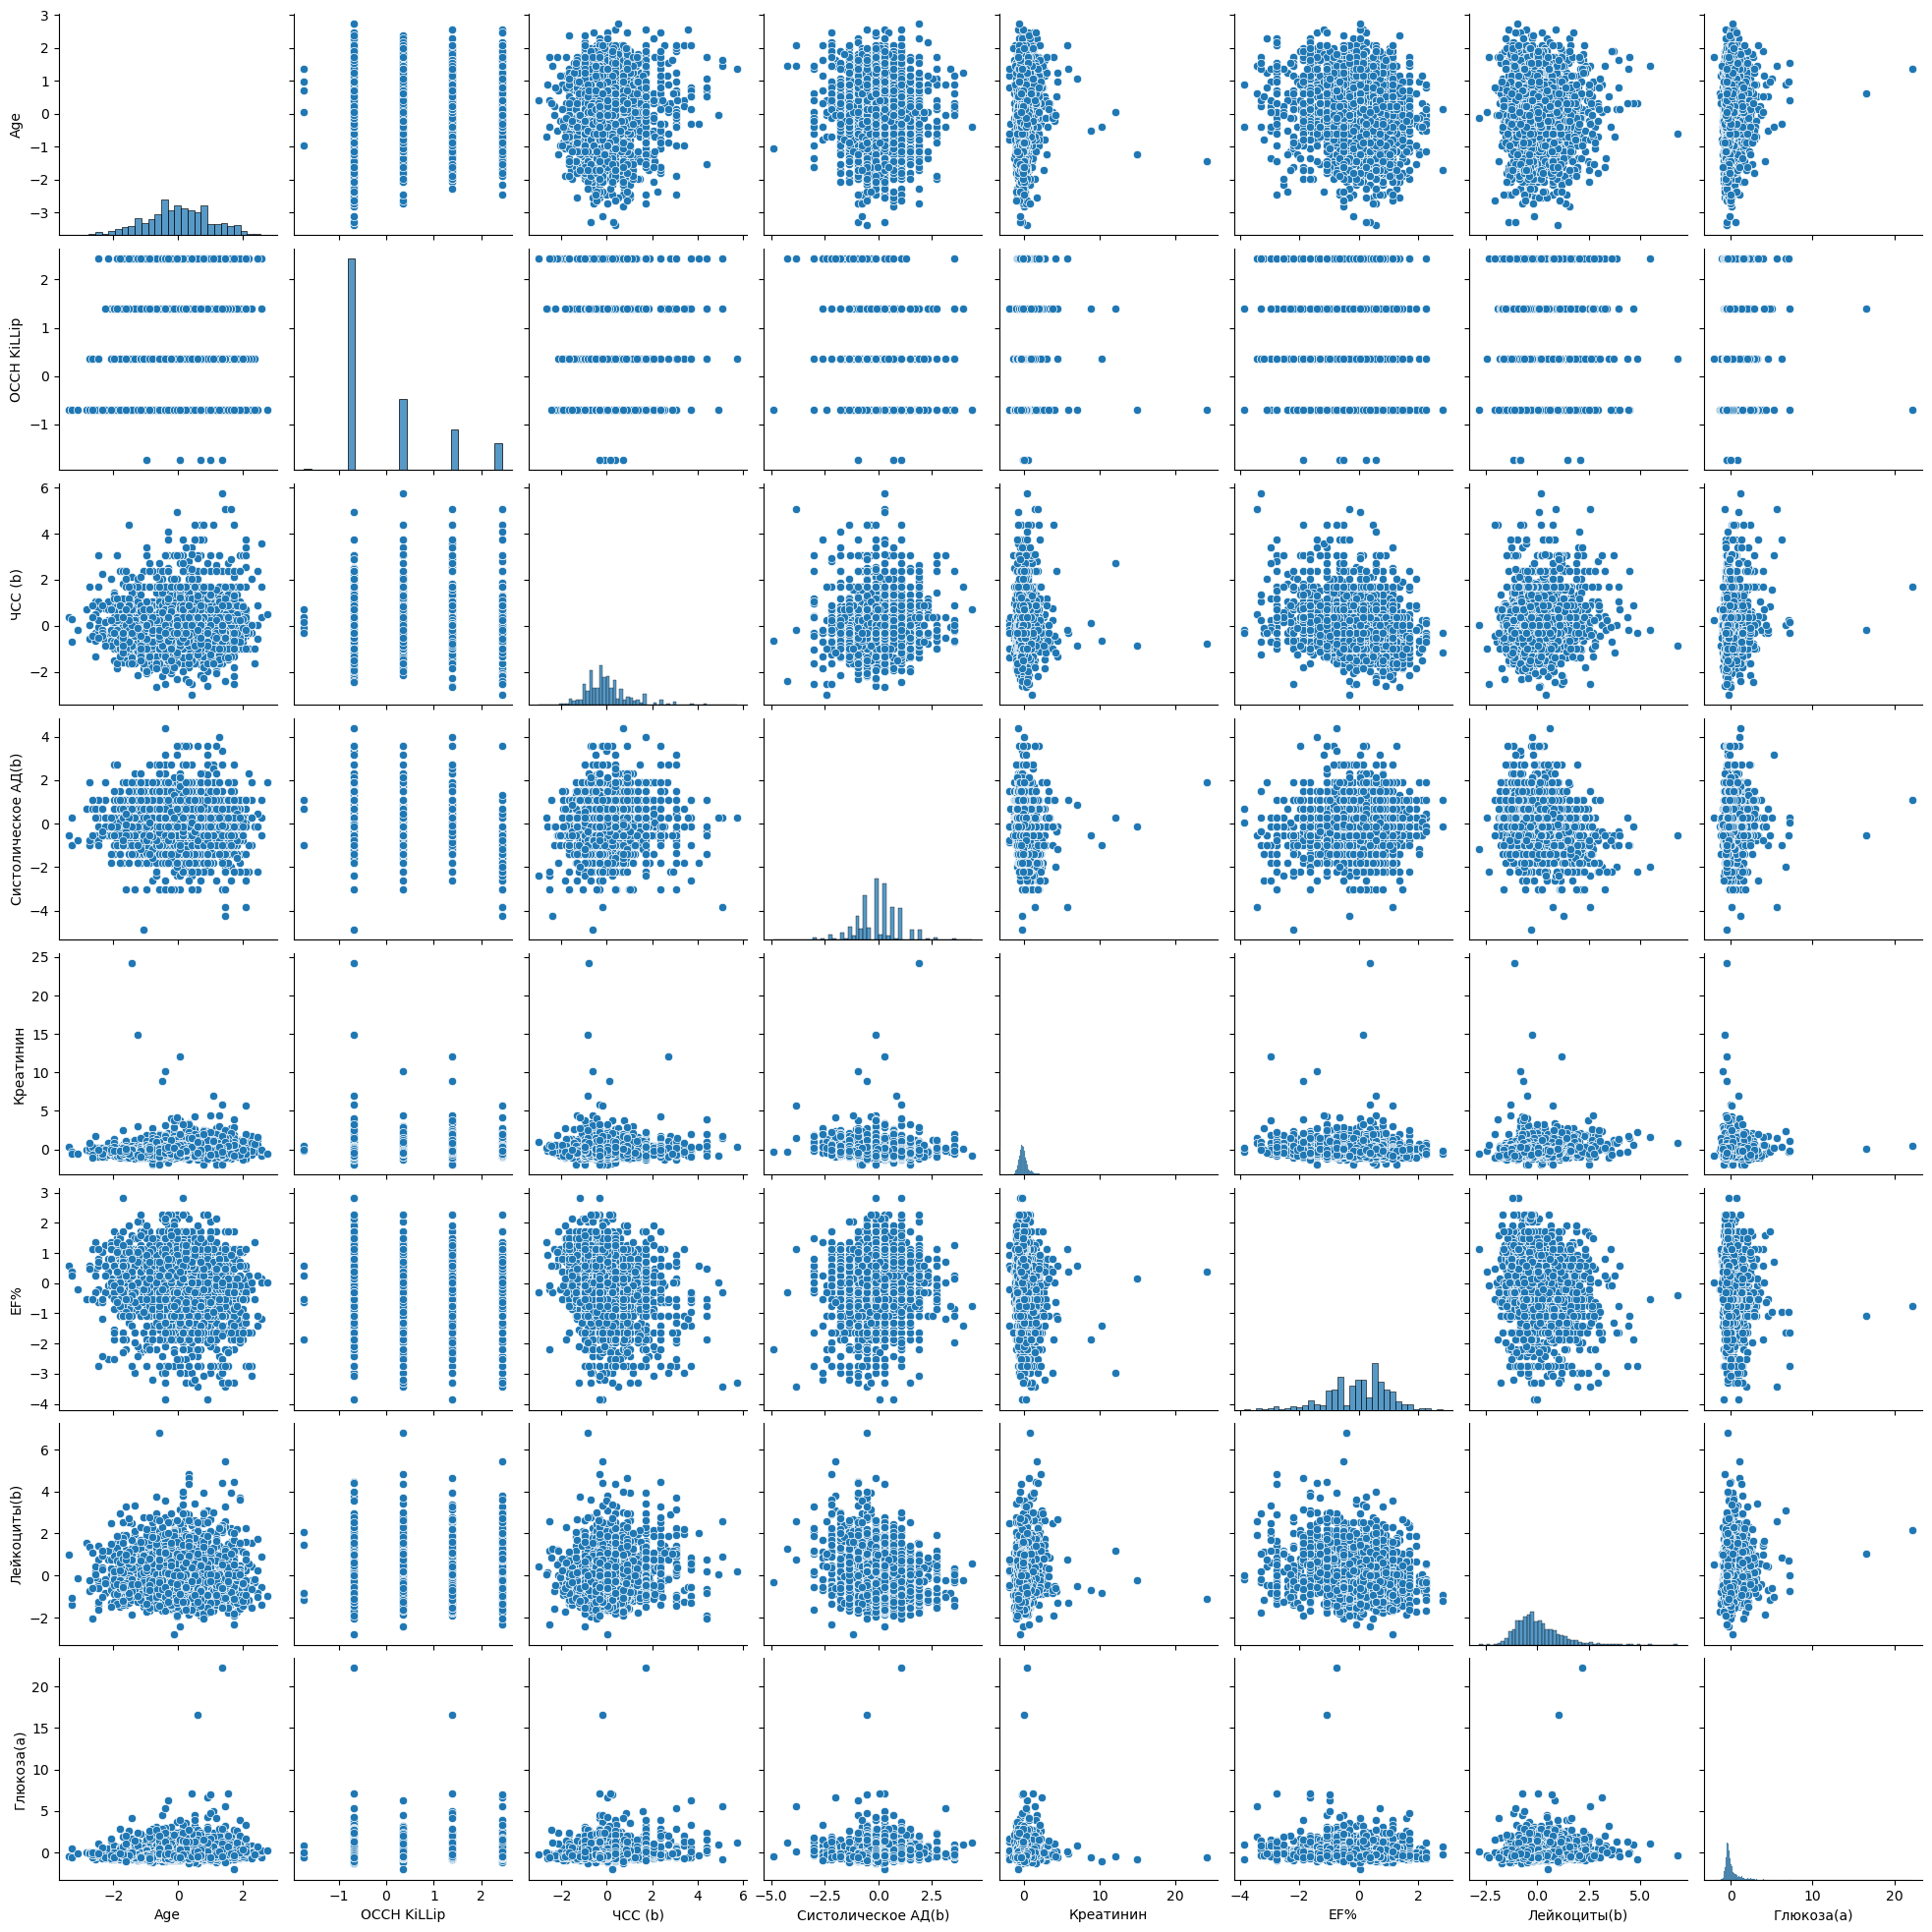

In [18]:
display(std_set['X_train'].describe())
sns.pairplot(std_set['X_train'])
plt.show()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,2419.000000,2419.000000,2419.000000,2419.000000,2419.000000,2419.000000,2419.000000,2419.000000
mean,0.551643,0.415771,0.343014,0.526888,0.075951,0.578297,0.293469,0.085391
std,0.163191,0.239999,0.114381,0.107998,0.038227,0.149864,0.104271,0.041159
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.439394,0.250000,0.269231,0.466667,0.058722,0.483333,0.221932,0.065951
50%,0.560606,0.250000,0.323077,0.511111,0.070117,0.600000,0.276762,0.075003
75%,0.666667,0.500000,0.384615,0.600000,0.083926,0.683333,0.347520,0.090392
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


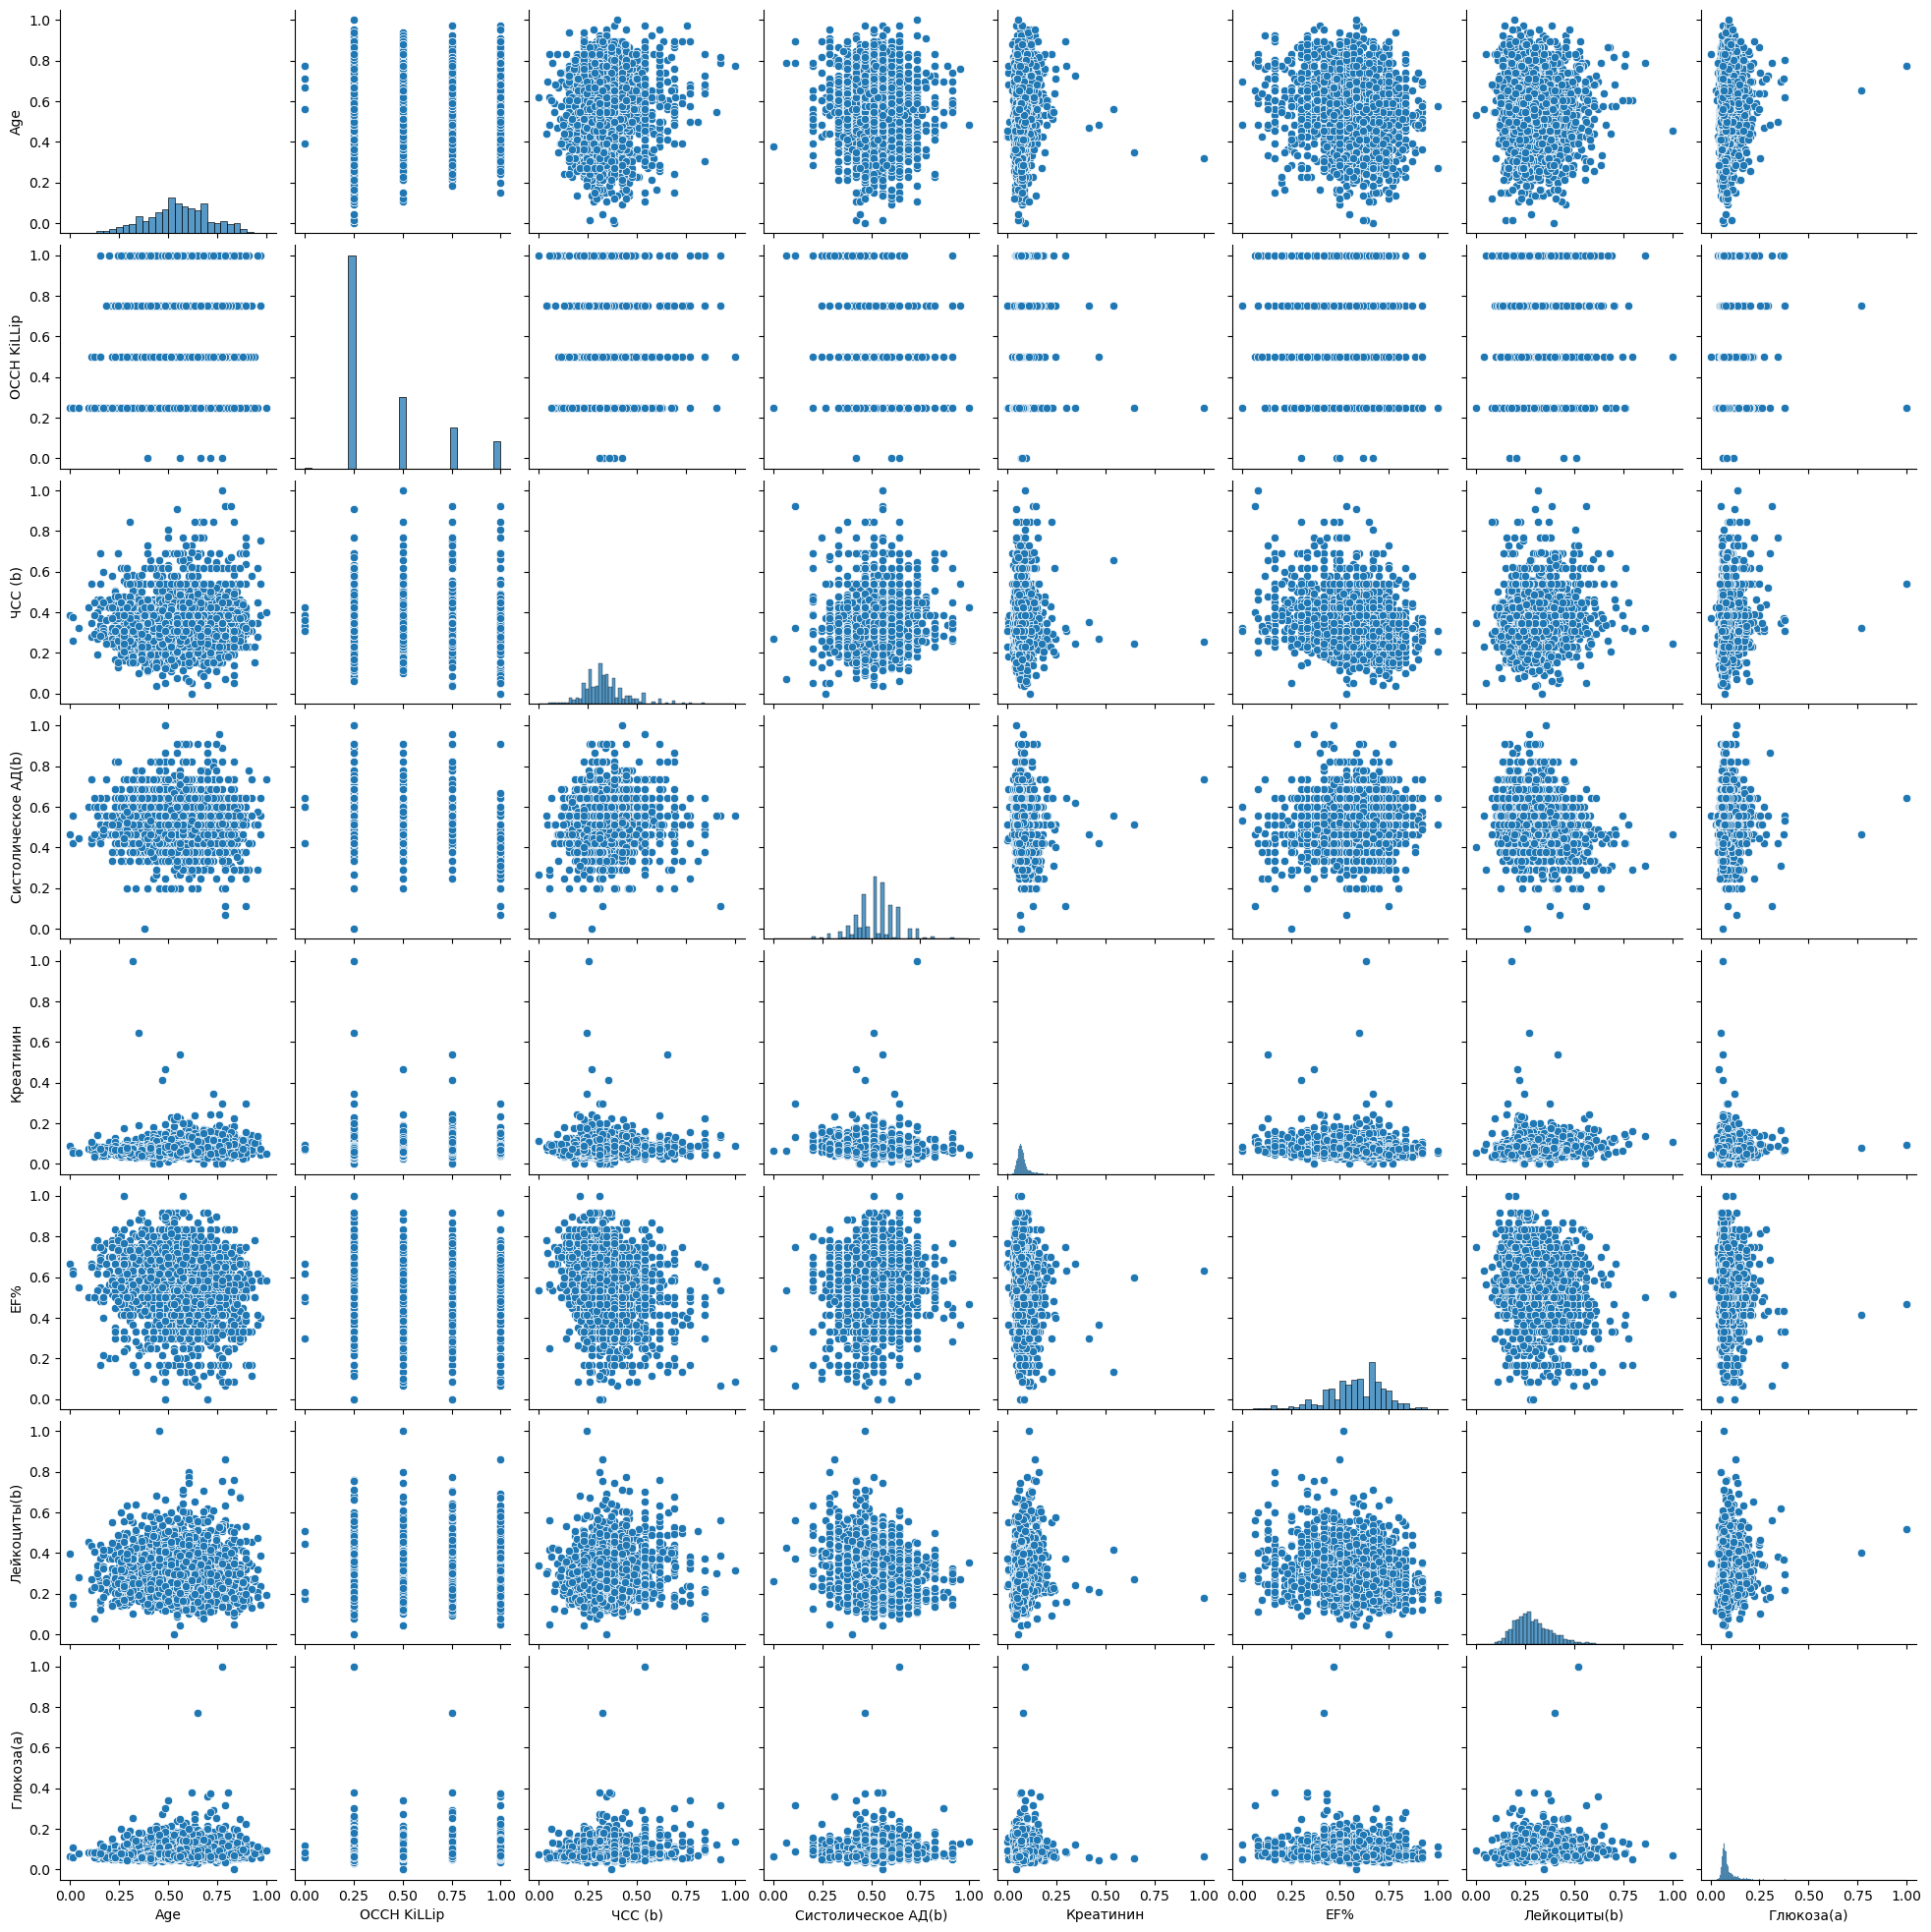

In [19]:
display(mm_set['X_train'].describe())
sns.pairplot(mm_set['X_train'])
plt.show()

There are different algorithms for calculating SHAP values:

1. Kernel SHAP: This method is model-agnostic and uses a weighted linear regression to estimate SHAP values. It is computationally expensive, especially for large datasets, but provides accurate explanations for any model. Use this method when you have a model that is not tree-based or linear, and you need a model-agnostic explanation. It is computationally expensive, so it's not suitable for large datasets or real-time explanations.

2. Tree SHAP: This method is designed specifically for tree-based models, such as decision trees, random forests, and gradient boosting machines. Tree SHAP is computationally efficient and provides exact SHAP values for tree-based models.

3. Linear SHAP: This method is specific to linear models. It calculates SHAP values by multiplying the feature values by the coefficients of the linear model.

4. Deep SHAP (DeepLIFT SHAP): This method is tailored for deep learning models, such as neural networks. Deep SHAP combines the DeepLIFT algorithm with SHAP value estimation, providing explanations for complex deep learning models.

5. Partition SHAP: This method is model-agnostic and uses a combination of random partitioning and model evaluations to compute SHAP values. It is more scalable than Kernel SHAP, but may be less accurate in some cases.

6. Monte Carlo SHAP: This method approximates SHAP values using random sampling, making it more computationally efficient than Kernel SHAP, but potentially less accurate. It can be used with any model.

In [20]:
def compute_mean_abs_shap_values(model, data, shap_algorithm):
    if shap_algorithm == 'kernel':
        explainer = shap.KernelExplainer(model.predict, data['X_train'])
    elif shap_algorithm == 'tree':
        explainer = shap.TreeExplainer(model, data['X_train'])
        shap_values = explainer(data['X_test'], check_additivity=False)
        return np.abs(shap_values.values).mean(axis=0) 
    elif shap_algorithm == 'linear':
        explainer = shap.LinearExplainer(model, data['X_train'])
    elif shap_algorithm == 'deep':
        explainer = shap.DeepExplainer(model, data['X_train'].values)
        shap_values = explainer.shap_values(data['X_test'])
        return np.abs(shap_values.values).mean(axis=0)
    elif shap_algorithm == 'partition':
        explainer = shap.PartitionExplainer(model.predict, data['X_train'])
    elif shap_algorithm == 'monte_carlo':
        explainer = shap.MonteCarloExplainer(model.predict, data['X_train'])
    elif shap_algorithm == 'gradient':
        explainer = shap.GradientExplainer(model, data['X_train'])
    else:
        raise ValueError("Invalid SHAP algorithm name. Valid options are: 'kernel', 'tree', 'linear', 'deep', 'partition', 'monte_carlo' or 'gradient'.")

    shap_values = explainer(data['X_test']) 
    mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

    return mean_abs_shap_values

4. Regression models

In [21]:
combined_weights_regression_df = None #this df contains weights of features calculated for regression models

In [22]:
def create_weights_df(feature_weights=None, model_info="", index_columns=X_train.columns, shap_values=None):
    # Create a MultiIndex for columns to include model_info and the corresponding values ('Weight', 'SHAP')
    columns = pd.MultiIndex.from_product([[model_info], ['Weight', 'SHAP']])

    # Create a DataFrame with feature names as index and feature_weights as 'Weight' values
    weights_df = pd.DataFrame(index=index_columns, columns=columns)
   
    if feature_weights is not None:
        weights_df[(model_info, 'Weight')] = feature_weights
    else:
        weights_df[(model_info, 'Weight')] = np.nan
    

    if shap_values is not None:
        weights_df[(model_info, 'SHAP')] = shap_values
    else:
        weights_df[(model_info, 'SHAP')] = np.nan

    return weights_df

Calculate weights for univariate linear regression.

In [23]:
def perform_univariate_linear_regression(scaled_data, model_info='')->pd.DataFrame:
    feature_weights = []
    for feature_name in  scaled_data['X_train'].columns:
        lr = LinearRegression()
        lr.fit( scaled_data['X_train'][[feature_name]], y_train)

        # Feature weight estimation
        feature_weights.append(lr.coef_[0])

    weights_df =create_weights_df(feature_weights, 
                                model_info=f'Univariate linear regression with {model_info}')
    return weights_df

Calculate weights and SHAP values for multivariate linear regression.

In [24]:
def perform_multivariate_linear_regression(scaled_data, model_info='')->pd.DataFrame:
    feature_weights = []

    lr_multi = LinearRegression()
    lr_multi.fit( scaled_data['X_train'], y_train)

    # Feature weight estimation
    feature_weights = lr_multi.coef_

    # Shapley values for Multivariate Linear Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(lr_multi, 
                                                        scaled_data, 
                                                        shap_algorithm='linear')
    
    weights_df = create_weights_df(feature_weights,                                   
                                    model_info=f'Multivariate linear regression with {model_info}',
                                    shap_values=mean_abs_shap_values)
    return weights_df

Calculate weights and shap values for logistic regression model

In [25]:
from sklearn.linear_model import LogisticRegression

def perform_logistic_regression(scaled_data, model_info=''):
    feature_weights = []

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit( scaled_data['X_train'], y_train)

    # Feature weight estimation
    feature_weights = log_reg.coef_[0]

    # Shapley values for Logistic Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(log_reg, 
                                                        scaled_data, 
                                                        shap_algorithm='linear')

    weights_df = create_weights_df(feature_weights,
                                    model_info=f'Logistic regression with {model_info}',
                                    shap_values=mean_abs_shap_values)
    return weights_df

Put all weight and shap values together

In [26]:
univariate_weights_orgnl_df = perform_univariate_linear_regression(original_set, model_info='NoScaler')
univariate_weights_std_df = perform_univariate_linear_regression(std_set, model_info='StandardScaler')
univariate_weights_mm_df = perform_univariate_linear_regression(mm_set, model_info='MinMaxScaler')

multivariate_weights_orgnl_shap_df = perform_multivariate_linear_regression(original_set, model_info='NoScaler')
multivariate_weights_std_shap_df = perform_multivariate_linear_regression(std_set, model_info='StandardScaler')
multivariate_weights_mm_shap_df = perform_multivariate_linear_regression(mm_set, model_info='MinMaxScaler')

logistic_regression_std_df = perform_logistic_regression(std_set, model_info='StandardScaler')

combined_weights_regression_df = pd.concat([univariate_weights_orgnl_df,
                                 univariate_weights_std_df,
                                 univariate_weights_mm_df,
                                 multivariate_weights_orgnl_shap_df,
                                 multivariate_weights_std_shap_df,
                                 multivariate_weights_mm_shap_df,
                                 logistic_regression_std_df
                                 ], axis=1)

In [27]:
display(combined_weights_regression_df)
display(combined_weights_regression_df.describe())

Univariate linear regression with NoScaler       \
                                                        Weight SHAP   
Age                                                   0.001952  NaN   
ОССН KiLLip                                           0.038732  NaN   
ЧСС (b)                                               0.002563  NaN   
Систолическое АД(b)                                  -0.000942  NaN   
Креатинин                                             0.000683  NaN   
EF%                                                  -0.005042  NaN   
Лейкоциты(b)                                          0.008000  NaN   
Глюкоза(a)                                            0.012037  NaN   

                    Univariate linear regression with StandardScaler       \
                                                              Weight SHAP   
Age                                                         0.021017  NaN   
ОССН KiLLip                                                 0.037175  NaN   
ЧСС (b)                                                     0.038096  NaN   
Систолическое АД(b)                                        -0.022884  NaN   
Креатинин                                                   0.035248  NaN   
EF%                                                        -0.045327  NaN   
Лейкоциты(b)                                                0.031942  NaN   
Глюкоза(a)                                                  0.038302  NaN   

                    Univariate linear regression with MinMaxScaler       \
                                                            Weight SHAP   
Age                                                       0.128814  NaN   
ОССН KiLLip                                               0.154929  NaN   
ЧСС (b)                                                   0.333132  NaN   
Систолическое АД(b)                                      -0.211933  NaN   
Креатинин                                                 0.922253  NaN   
EF%                                                      -0.302516  NaN   
Лейкоциты(b)                                              0.306399  NaN   
Глюкоза(a)                                                0.930795  NaN   

                    Multivariate linear regression with NoScaler            \
                                                          Weight      SHAP   
Age                                                     0.000741  0.006676   
ОССН KiLLip                                             0.016322  0.012526   
ЧСС (b)                                                 0.001552  0.016660   
Систолическое АД(b)                                    -0.000488  0.008780   
Креатинин                                               0.000486  0.014459   
EF%                                                    -0.002858  0.020208   
Лейкоциты(b)                                            0.003110  0.009340   
Глюкоза(a)                                              0.008132  0.013905   

                    Multivariate linear regression with StandardScaler  \
                                                                Weight   
Age                                                           0.007983   
ОССН KiLLip                                                   0.015666   
ЧСС (b)                                                       0.023066   
Систолическое АД(b)                                          -0.011855   
Креатинин                                                     0.025098   
EF%                                                          -0.025697   
Лейкоциты(b)                                                  0.012418   
Глюкоза(a)                                                    0.025877   

                               \
                         SHAP   
Age                  0.006326   
ОССН KiLLip          0.013101   
ЧСС (b)              0.017009   
Систолическое АД(b)  0.009286   
Креатинин            0.015378   
EF%                  0.020961   
Л

Univariate linear regression with NoScaler       \
                                          Weight SHAP   
count                                   8.000000  0.0   
mean                                    0.007248  NaN   
std                                     0.013763  NaN   
min                                    -0.005042  NaN   
25%                                     0.000277  NaN   
50%                                     0.002257  NaN   
75%                                     0.009009  NaN   
max                                     0.038732  NaN   

      Univariate linear regression with StandardScaler       \
                                                Weight SHAP   
count                                         8.000000  0.0   
mean                                          0.016696  NaN   
std                                           0.032410  NaN   
min                                          -0.045327  NaN   
25%                                           0.010042  NaN   
50%                                           0.033595  NaN   
75%                                           0.037405  NaN   
max                                           0.038302  NaN   

      Univariate linear regression with MinMaxScaler       \
                                              Weight SHAP   
count                                       8.000000  0.0   
mean                                        0.282734  NaN   
std                                         0.456588  NaN   
min                                        -0.302516  NaN   
25%                                         0.043628  NaN   
50%                                         0.230664  NaN   
75%                                         0.480412  NaN   
max                                         0.930795  NaN   

      Multivariate linear regression with NoScaler            \
                                            Weight      SHAP   
count                                     8.000000  8.000000   
mean                                      0.003375  0.012819   
std                                       0.006126  0.004463   
min                                      -0.002858  0.006676   
25%                                       0.000243  0.009200   
50%                                       0.001146  0.013216   
75%                                       0.004366  0.015009   
max                                       0.016322  0.020208   

      Multivariate linear regression with StandardScaler            \
                                                  Weight      SHAP   
count                                           8.000000  8.000000   
mean                                            0.009070  0.013515   
std                                             0.018662  0.004899   
min                                            -0.025697  0.006326   
25%                                             0.003024  0.009356   
50%                                             0.014042  0.014240   
75%                                             0.023574  0.016762   
max                                             0.025877  0.020961   

      Multivariate linear regression with MinMaxScaler            \
                                                Weight      SHAP   
count                                         8.000000  8.000000   
mean                                          0.179909  0.024801   
std                                           0.309550  0.017503   
min                                          -0.171506  0.007158   
25%                                           0.009248  0.013612   
50%                                           0.092205  0.017288   
75%                                           0.308491  0.033106   
max                                           0.656684  0.052089   

      Logistic regression with StandardScaler            
                                       Weight      SHAP  
count                                8.000000  8.00000

Let's plot these values.

In [28]:
def flatten_df(df)->pd.DataFrame:
    # We need to flatten the table
    long_format_df = df.reset_index().melt(id_vars='index', var_name=['Model Info', 'Value Type'], value_name='Value')
    long_format_df = long_format_df.rename(columns={'index': 'Feature'})

    # Filter out rows corresponding to the SHAP values for univariate regression, because they are NaN
    shap_mask = long_format_df['Value Type'] == 'SHAP'
    univariate_mask = long_format_df['Model Info'].str.startswith('Univariate')
    flat_df = long_format_df.loc[~(shap_mask & univariate_mask)]
    return flat_df

In [29]:
def plot_values(flat_df, value_type='Weight'):
    weights_df = flat_df.loc[flat_df['Value Type'] == value_type]
    plt.figure(figsize=(15, 20))
    ax = sns.barplot(data=weights_df, x='Model Info', y='Value', hue='Feature', palette='deep')

    for p in ax.patches:
        y_offset = 3 if p.get_height() >= 0 else -15
        ax.annotate(f"{p.get_height():.3f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=6, color='black', 
                    xytext=(0, y_offset), textcoords='offset points')

    # plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', borderaxespad=0.)
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.title(f'Feature {value_type} for Different Models')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

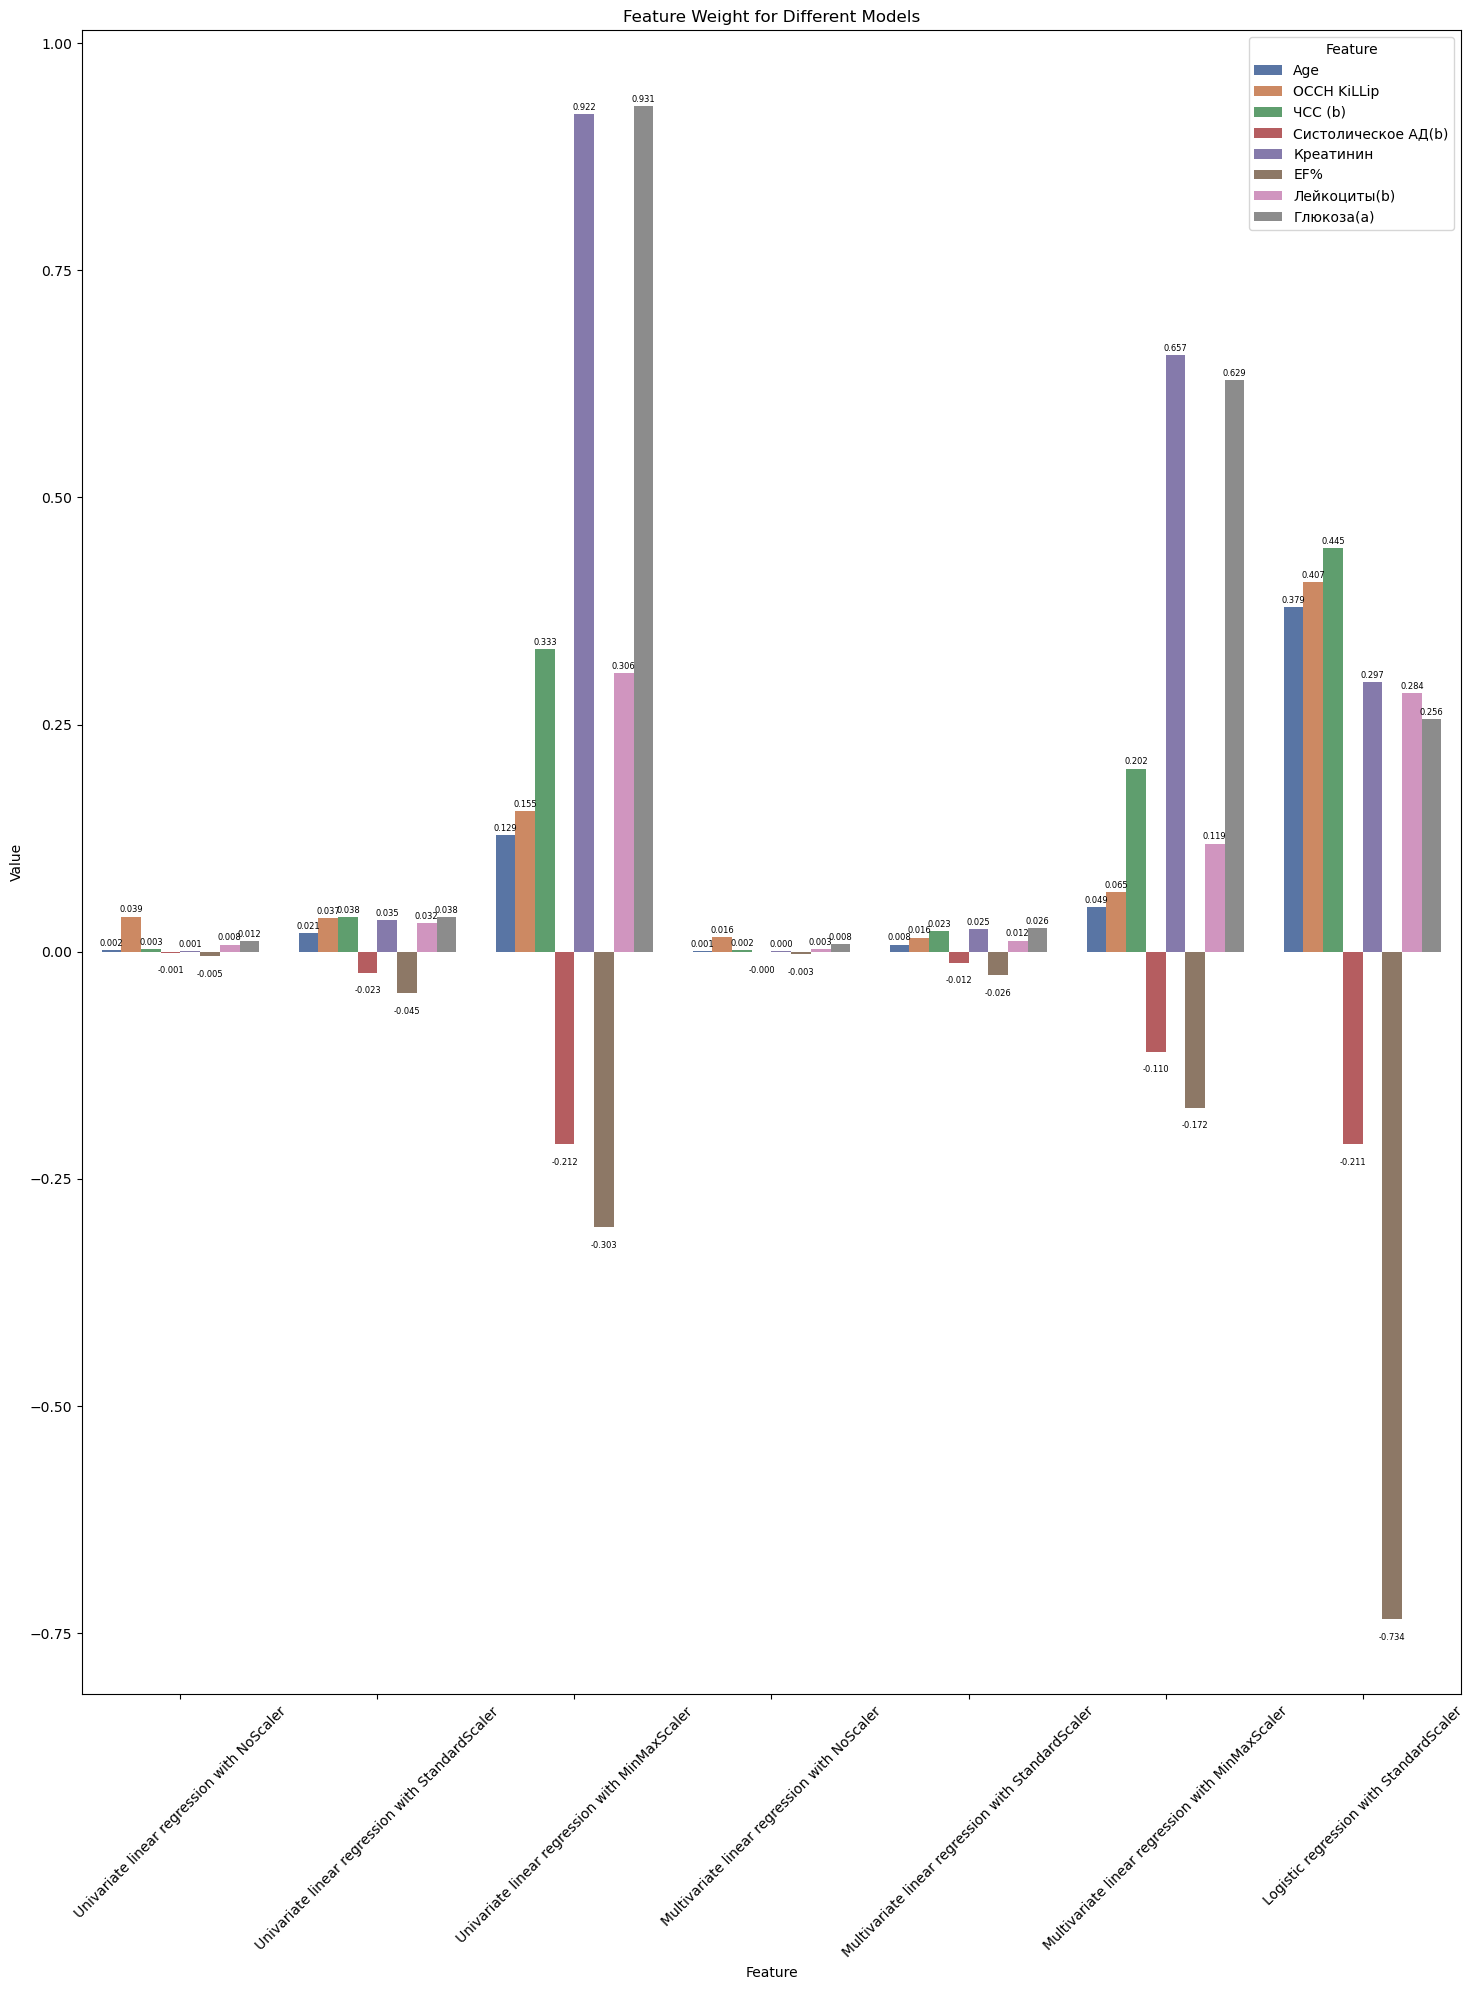

In [30]:
plot_values(flatten_df(combined_weights_regression_df), "Weight")

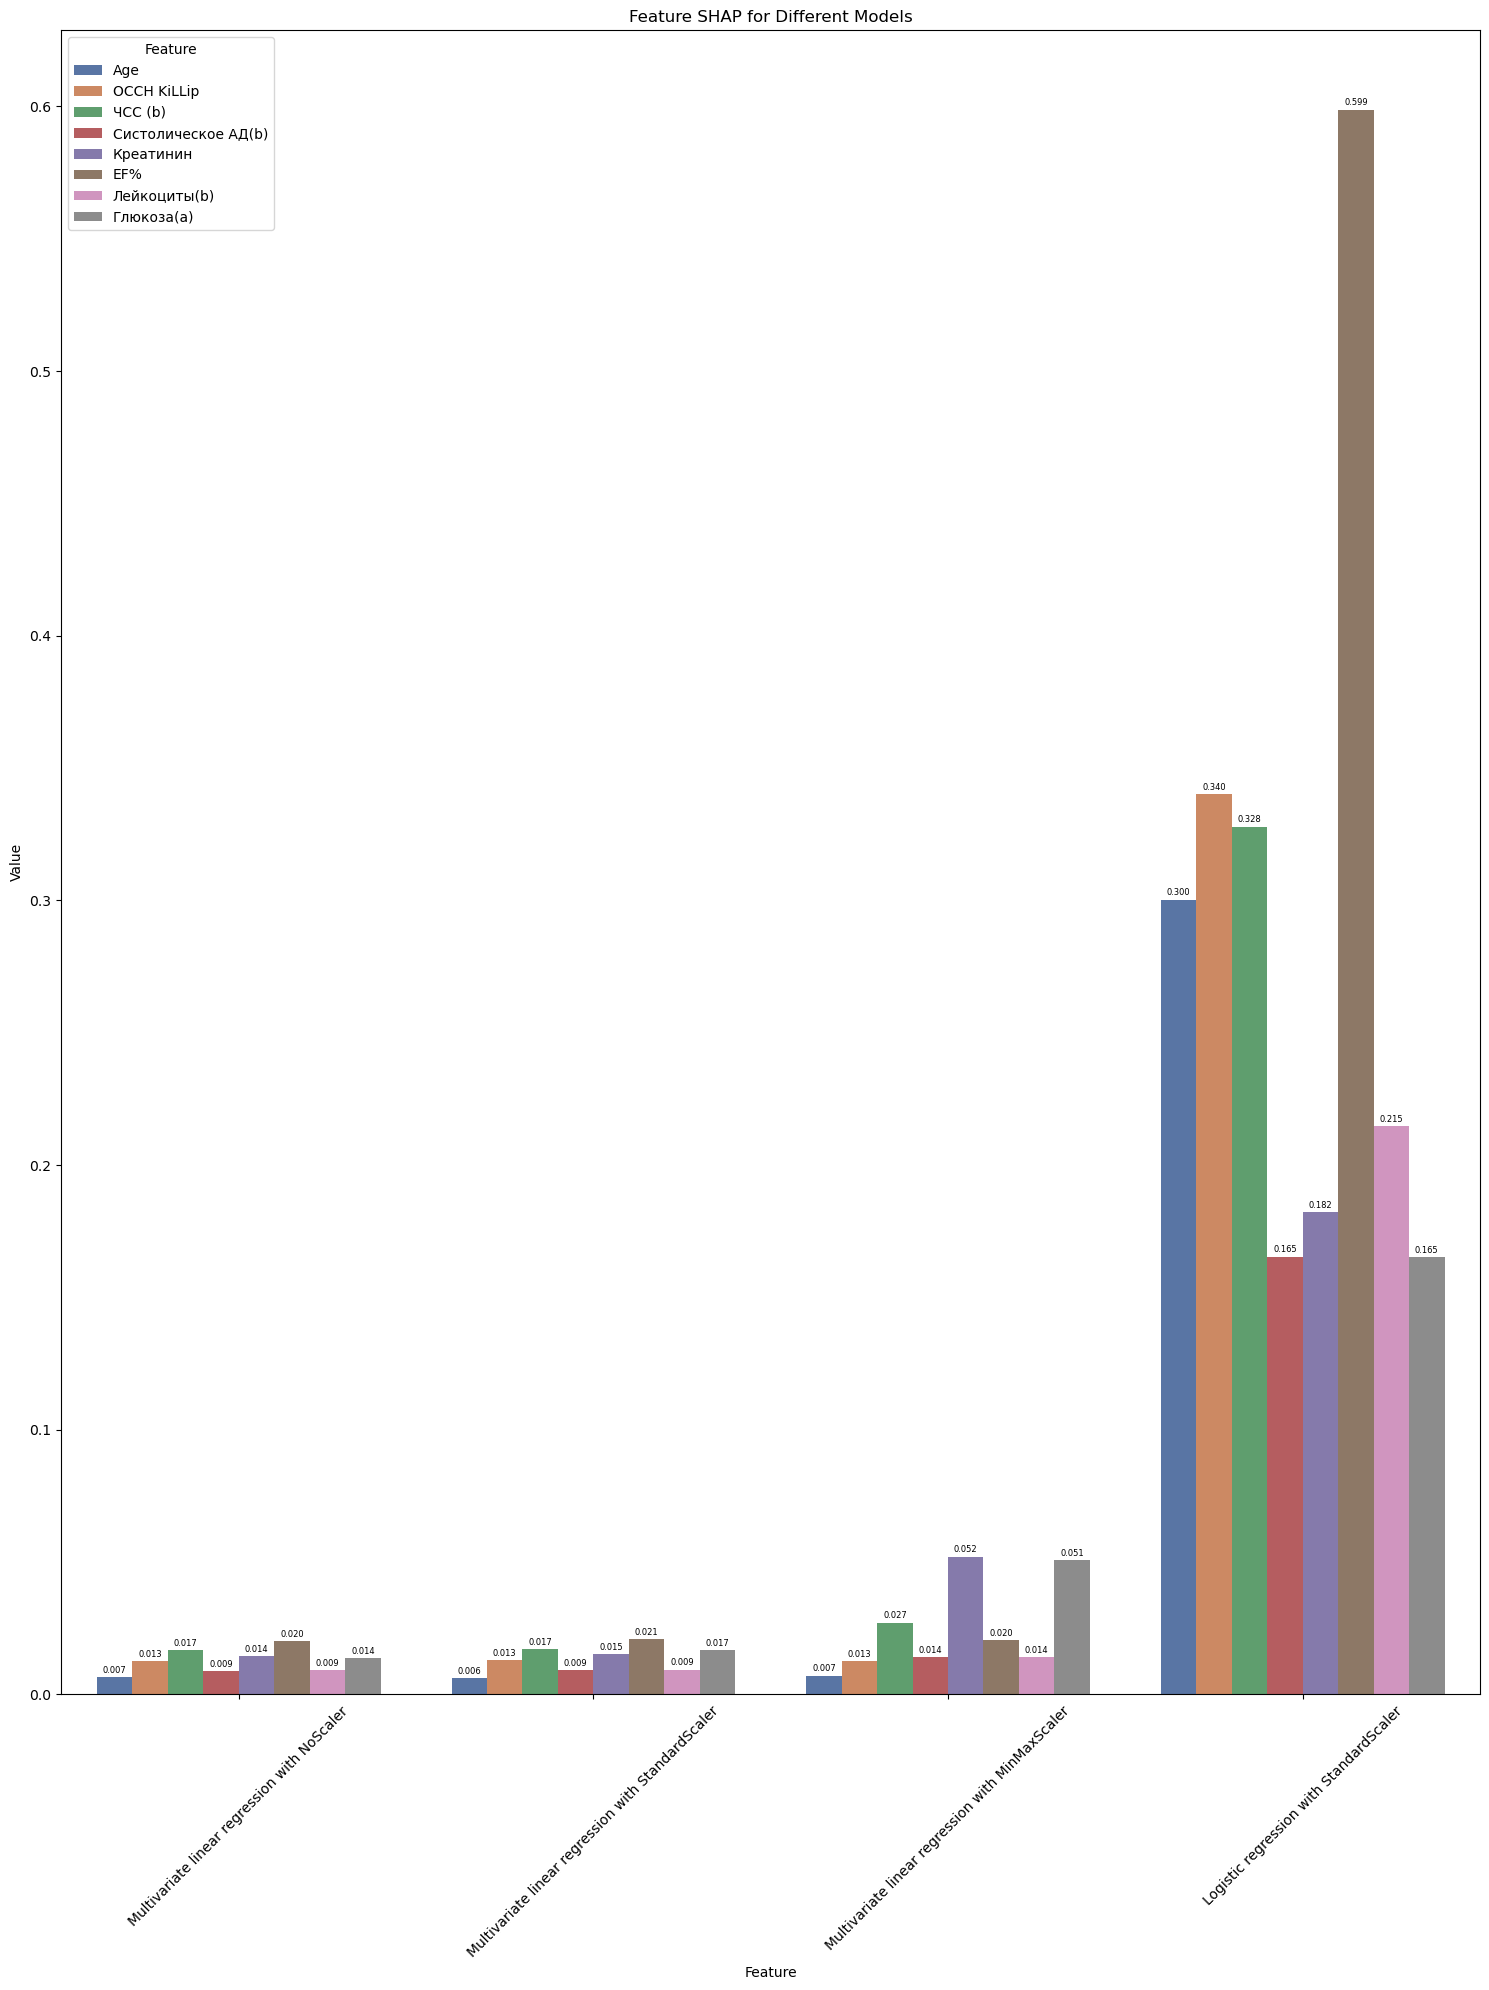

In [31]:
plot_values(flatten_df(combined_weights_regression_df), "SHAP")

5. Gradient Boosting model

In [32]:
combined_weights_tree_df = None #this df contains weights of features calculated for tree based models

In [33]:
import xgboost as xgb

def perform_xgboost_regression(scaled_data, model_info=''):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=25)
    xgb_model.fit(scaled_data['X_train'], y_train)
    

    # Feature importance using XGBoost's built-in feature importance metric
    feature_importances = xgb_model.feature_importances_

    # Shapley values for XGBoost Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(xgb_model, 
                                                        scaled_data, 
                                                        shap_algorithm='tree')

    weights_df = create_weights_df(feature_importances,
                                    model_info=f'XGBoost regression - {model_info}',
                                    index_columns=scaled_data['X_train'].columns,
                                    shap_values=mean_abs_shap_values)
    return weights_df

6. Random Forest model

In [34]:
def perform_forest_regression(scaled_data, model_info=''):
    rf_model = RandomForestRegressor(n_jobs=-1, random_state=25)
    rf_model.fit(scaled_data['X_train'], y_train)

    # Feature importance using RandomForest's built-in feature importance metric
    feature_importances = rf_model.feature_importances_

    # Shapley values for RandomForest Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(rf_model, 
                                                        scaled_data, 
                                                        shap_algorithm='tree')

    weights_df = create_weights_df(feature_importances,
                                    model_info=f'RandomForest regression - {model_info}',
                                    index_columns=scaled_data['X_train'].columns,
                                    shap_values=mean_abs_shap_values)
    return weights_df

This function will change the order of columns for our tree models

In [35]:
def carousel_wrapper(scaled_data, model_function, model_info=''):
    n_columns = len(scaled_data['X_train'].columns)
    all_weights_df = []

    for i in range(n_columns):
        # Rotate columns based on round-robin principle
        rotated_columns = np.roll(scaled_data['X_train'].columns, shift=-i)
        
        # Rearrange the columns in the dataset
        rotated_data = {}
        for key in scaled_data:
            # Assign the rotated columns to the data
            rotated_data[key] = scaled_data[key][rotated_columns]

        # Call the provided model_function with the new order of columns
        weights_df = model_function(rotated_data, model_info=f'{model_info} - Rotation {i+1}')
        all_weights_df.append(weights_df)
    
    # Combine all the weights dataframes into a single dataframe using join
    combined_weights_df = all_weights_df[0].join(all_weights_df[1:])

    return combined_weights_df


In [36]:
xgboost_weights_shap_df = carousel_wrapper(original_set, perform_xgboost_regression)

In [37]:
display(xgboost_weights_shap_df)
display(xgboost_weights_shap_df.describe())

XGBoost regression -  - Rotation 1            \
                                                Weight      SHAP   
Age                                           0.079239  0.012124   
ОССН KiLLip                                   0.062564  0.007031   
ЧСС (b)                                       0.125158  0.018632   
Систолическое АД(b)                           0.153430  0.010451   
Креатинин                                     0.127759  0.013897   
EF%                                           0.163815  0.019597   
Лейкоциты(b)                                  0.138567  0.007425   
Глюкоза(a)                                    0.149467  0.013463   

                    XGBoost regression -  - Rotation 2            \
                                                Weight      SHAP   
Age                                           0.074692  0.009484   
ОССН KiLLip                                   0.061585  0.007974   
ЧСС (b)                                       0.134603  0.017461   
Систолическое АД(b)                           0.141384  0.012437   
Креатинин                                     0.116319  0.012877   
EF%                                           0.185749  0.024299   
Лейкоциты(b)                                  0.149640  0.009167   
Глюкоза(a)                                    0.136029  0.012559   

                    XGBoost regression -  - Rotation 3            \
                                                Weight      SHAP   
Age                                           0.074822  0.009992   
ОССН KiLLip                                   0.114193  0.007307   
ЧСС (b)                                       0.096868  0.016089   
Систолическое АД(b)                           0.137756  0.010753   
Креатинин                                     0.116888  0.014222   
EF%                                           0.159893  0.021713   
Лейкоциты(b)                                  0.140736  0.007769   
Глюкоза(a)                                    0.158844  0.014708   

                    XGBoost regression -  - Rotation 4            \
                                                Weight      SHAP   
Age                                           0.103944  0.009464   
ОССН KiLLip                                   0.106137  0.008629   
ЧСС (b)                                       0.108418  0.015755   
Систолическое АД(b)                           0.111630  0.009493   
Креатинин                                     0.114258  0.011940   
EF%                                           0.178203  0.022689   
Лейкоциты(b)                                  0.131054  0.008630   
Глюкоза(a)                                    0.146357  0.014952   

                    XGBoost regression -  - Rotation 5            \
                                                Weight      SHAP   
Age                                           0.090345  0.009602   
ОССН KiLLip                                   0.096684  0.007203   
ЧСС (b)                                       0.123133  0.016764   
Систолическое АД(b)                           0.156134  0.010543   
Креатинин                                     0.091854  0.011970   
EF%                                           0.167521  0.021998   
Лейкоциты(b)                                  0.134207  0.007131   
Глюкоза(a)                                    0.140122  0.015406   

                    XGBoost regression -  - Rotation 6            \
                                                Weight      SHAP   
Age                                           0.105101  0.010135   
ОССН KiLLip                                   0.102195  0.008233   
ЧСС (b)                                       0.104987  0.016384   
Систолическое АД(b)                           0.167447  0.009851   
Креатинин                                     0.134479  0.011909   
EF%                                           0.122371  0.022539   
Лейкоциты(b)                                  0.124435  0.009008   
Глю

XGBoost regression -  - Rotation 1            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012827   
std                             0.036051  0.004629   
min                             0.062564  0.007031   
25%                             0.113678  0.009694   
50%                             0.133163  0.012793   
75%                             0.150458  0.015081   
max                             0.163815  0.019597   

      XGBoost regression -  - Rotation 2            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.013282   
std                             0.040369  0.005342   
min                             0.061585  0.007974   
25%                             0.105912  0.009405   
50%                             0.135316  0.012498   
75%                             0.143448  0.014023   
max                             0.185749  0.024299   

      XGBoost regression -  - Rotation 3            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012819   
std                             0.029917  0.004833   
min                             0.074822  0.007307   
25%                             0.109862  0.009436   
50%                             0.127322  0.012487   
75%                             0.145263  0.015053   
max                             0.159893  0.021713   

      XGBoost regression -  - Rotation 4            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012694   
std                             0.025889  0.004909   
min                             0.103944  0.008629   
25%                             0.107848  0.009255   
50%                             0.112944  0.010717   
75%                             0.134880  0.015152   
max                             0.178203  0.022689   

      XGBoost regression -  - Rotation 5            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012577   
std                             0.029751  0.005157   
min                             0.090345  0.007131   
25%                             0.095477  0.009003   
50%                             0.128670  0.011257   
75%                             0.144125  0.015746   
max                             0.167521  0.021998   

      XGBoost regression -  - Rotation 6            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012819   
std                             0.022075  0.004816   
min                             0.102195  0.008233   
25%                             0.105072  0.009641   
50%                             0.123403  0.011022   
75%                             0.135606  0.014965   
max                             0.167447  0.022539   

      XGBoost regression -  - Rotation 7            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012653   
std                             0.027610  0.004344   
min                             0.085258  0.007642   
25%                             0.099607  0.009680   
50%                             0.131155  0.011967   
75%                             0.147328  0.015078   
max                             0.155644  0.020322   

      XGBoost regression -  - Rotation 8            
                                  Weight      SHAP  
count                           8.000000  8.000000  
mean                            0.125000  0.012959  
std    

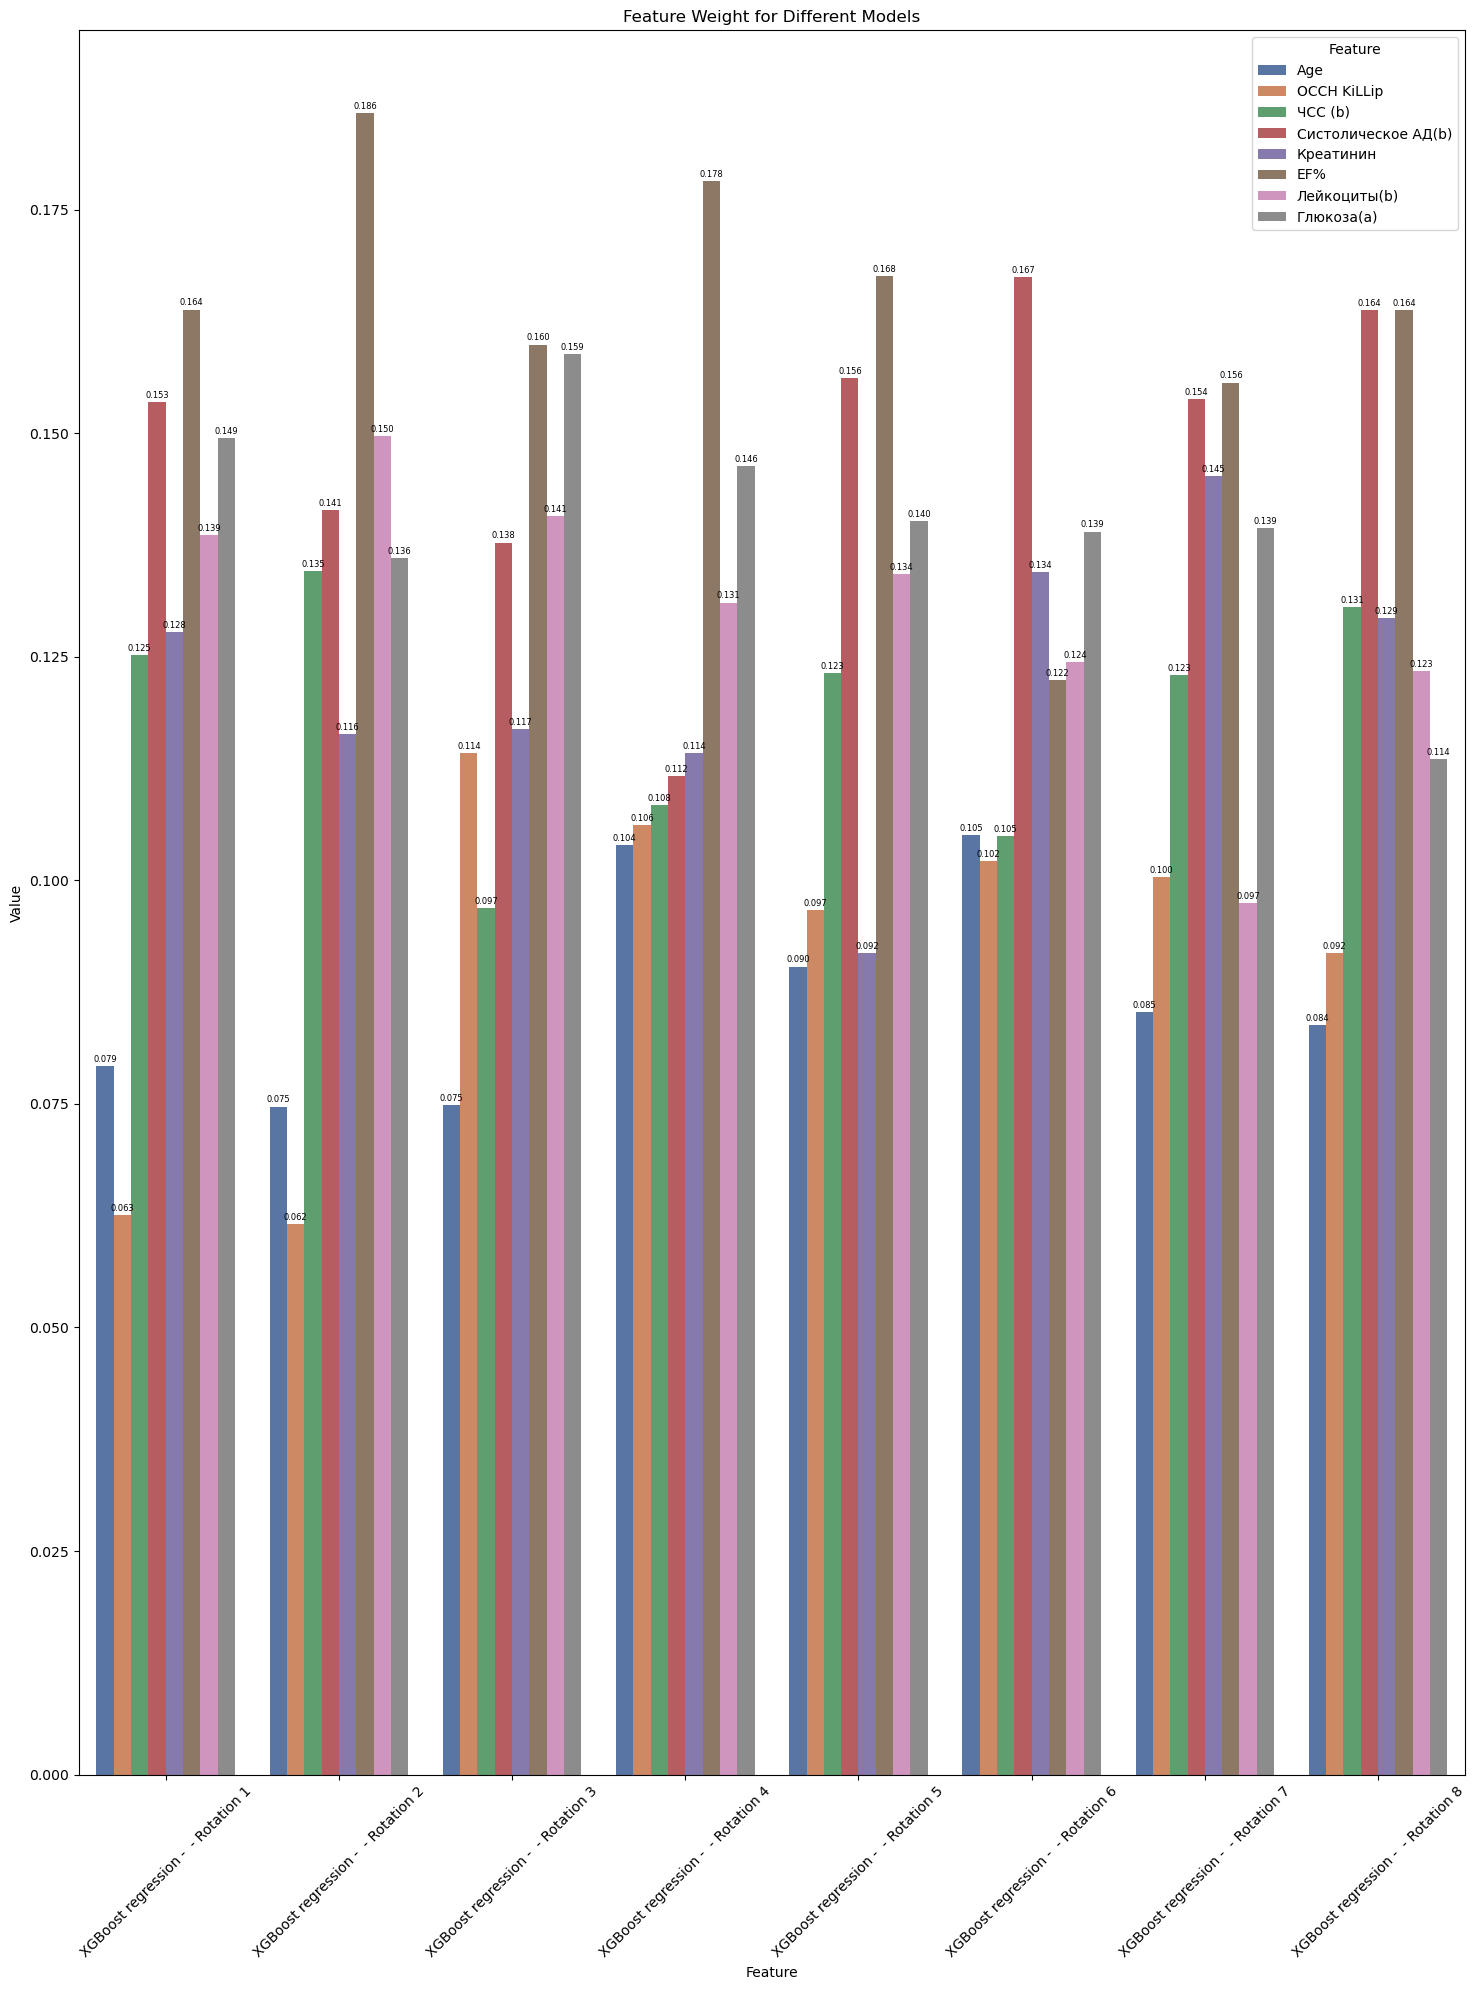

In [38]:
plot_values(flatten_df(xgboost_weights_shap_df), "Weight")

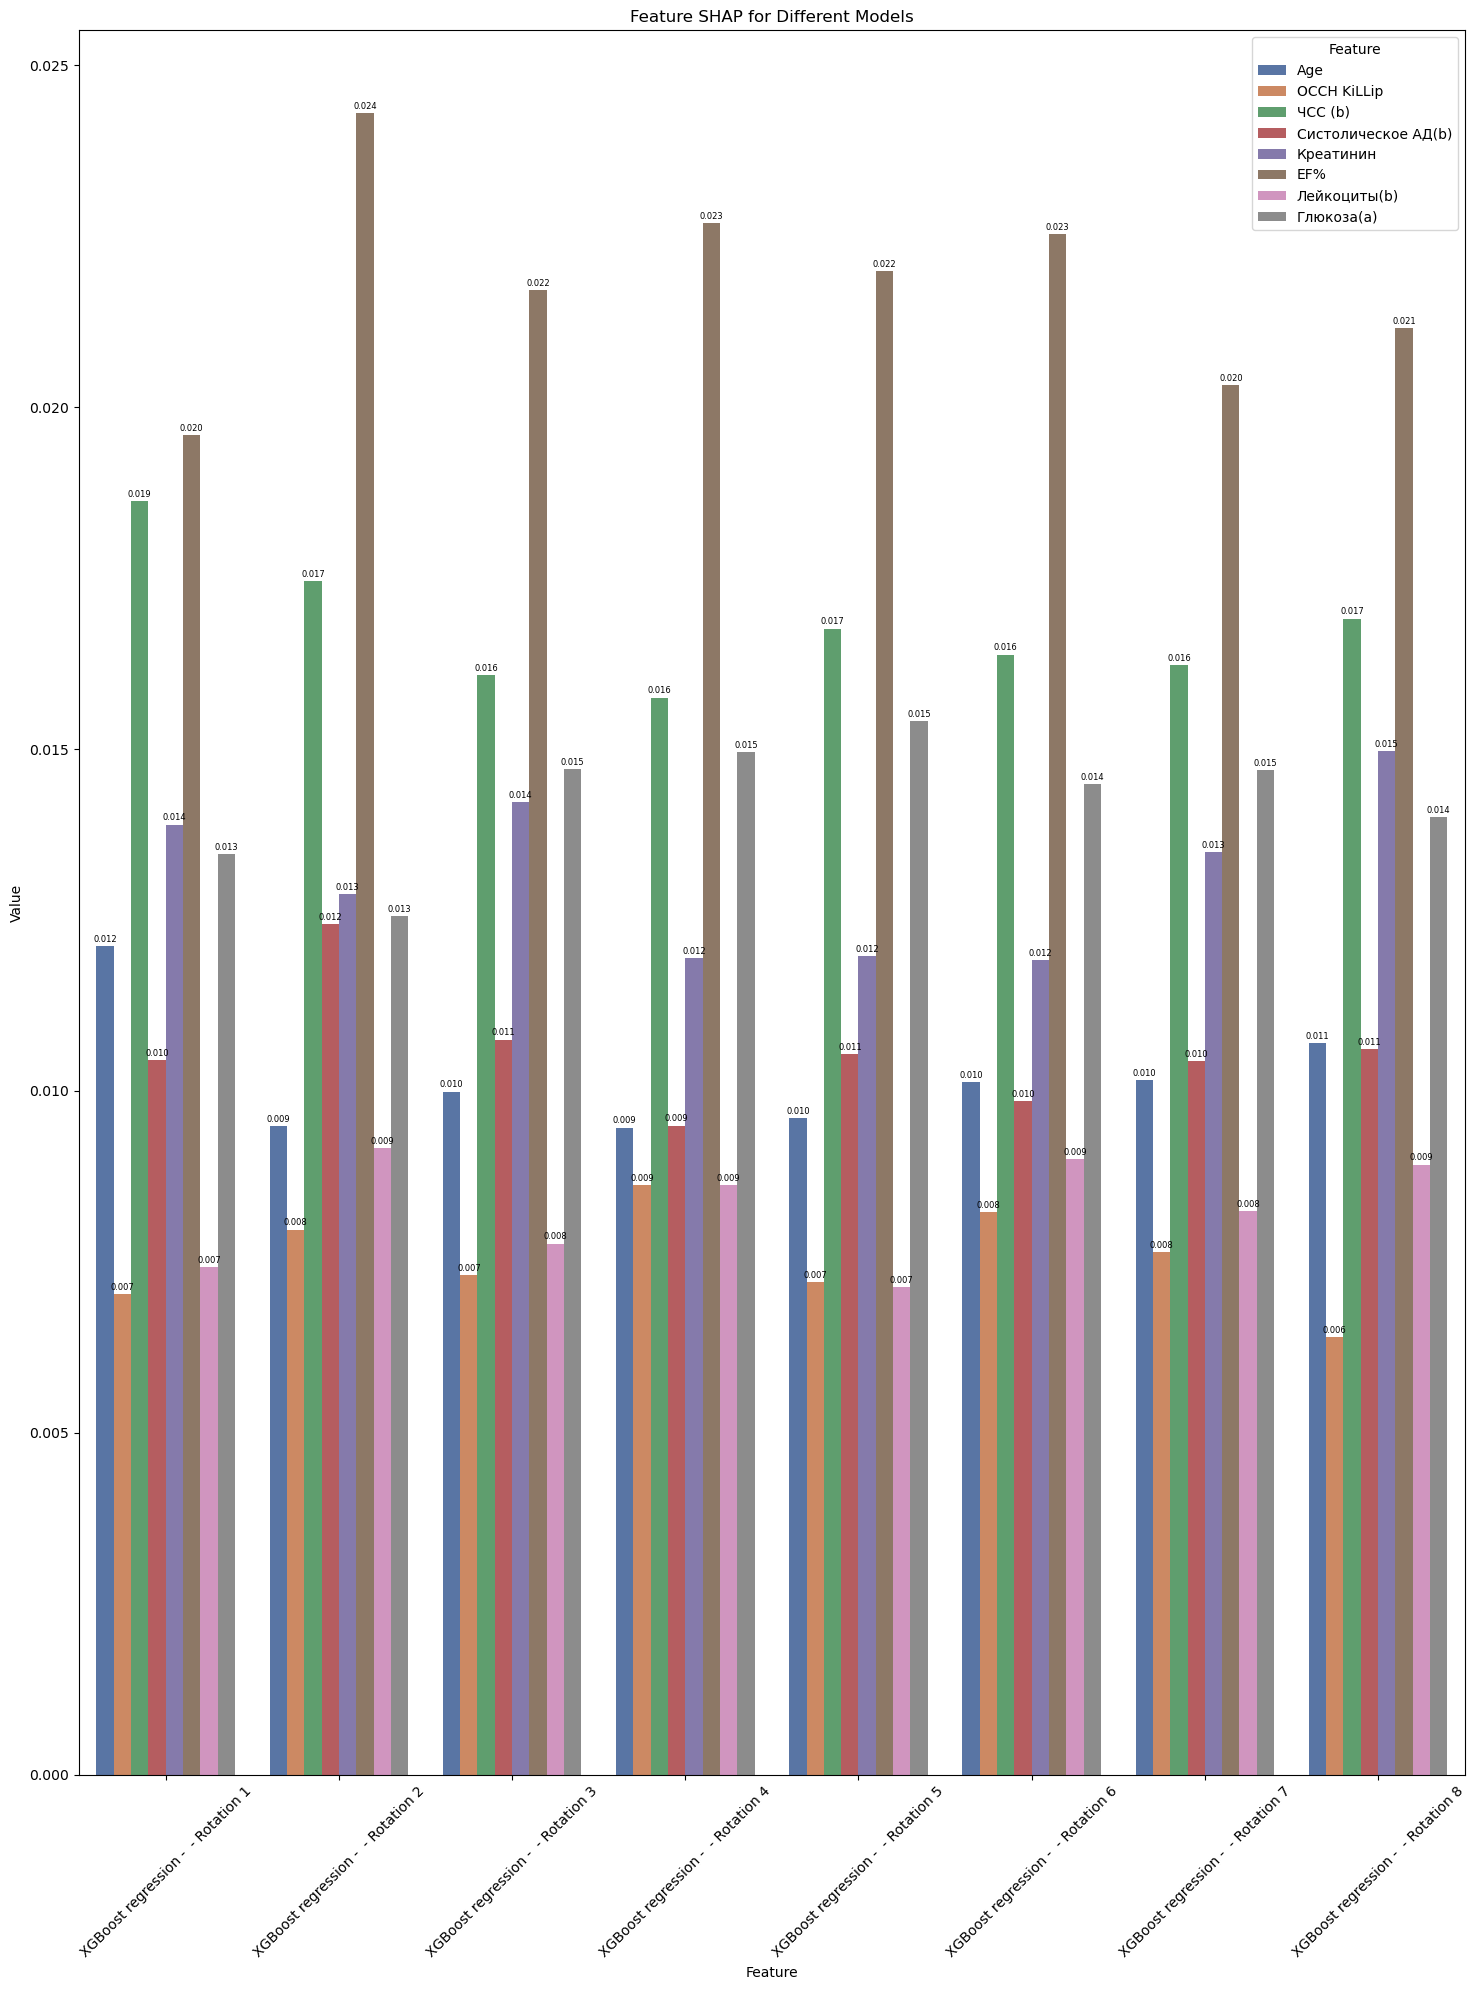

In [39]:
plot_values(flatten_df(xgboost_weights_shap_df), "SHAP")

In [40]:
forest_weights_shap_df = carousel_wrapper(original_set, perform_forest_regression)

In [41]:
display(forest_weights_shap_df)
display(forest_weights_shap_df.describe())

RandomForest regression -  - Rotation 1            \
                                                     Weight      SHAP   
Age                                                0.096485  0.007900   
ОССН KiLLip                                        0.038046  0.006507   
ЧСС (b)                                            0.132944  0.014666   
Систолическое АД(b)                                0.105337  0.009073   
Креатинин                                          0.155658  0.010833   
EF%                                                0.149334  0.022957   
Лейкоциты(b)                                       0.139637  0.004927   
Глюкоза(a)                                         0.182558  0.009376   

                    RandomForest regression -  - Rotation 2            \
                                                     Weight      SHAP   
Age                                                0.096124  0.008068   
ОССН KiLLip                                        0.038303  0.006753   
ЧСС (b)                                            0.134575  0.014567   
Систолическое АД(b)                                0.106421  0.009343   
Креатинин                                          0.153385  0.011329   
EF%                                                0.148289  0.023504   
Лейкоциты(b)                                       0.142190  0.005101   
Глюкоза(a)                                         0.180713  0.008999   

                    RandomForest regression -  - Rotation 3            \
                                                     Weight      SHAP   
Age                                                0.092787  0.008150   
ОССН KiLLip                                        0.038605  0.006740   
ЧСС (b)                                            0.131901  0.014504   
Систолическое АД(b)                                0.108952  0.009003   
Креатинин                                          0.158138  0.010883   
EF%                                                0.147594  0.023288   
Лейкоциты(b)                                       0.137937  0.005217   
Глюкоза(a)                                         0.184086  0.009789   

                    RandomForest regression -  - Rotation 4            \
                                                     Weight      SHAP   
Age                                                0.096027  0.007970   
ОССН KiLLip                                        0.039632  0.006816   
ЧСС (b)                                            0.134524  0.014753   
Систолическое АД(b)                                0.109764  0.009141   
Креатинин                                          0.154357  0.010463   
EF%                                                0.147313  0.023218   
Лейкоциты(b)                                       0.138012  0.004882   
Глюкоза(a)                                         0.180370  0.009577   

                    RandomForest regression -  - Rotation 5            \
                                                     Weight      SHAP   
Age                                                0.090244  0.007806   
ОССН KiLLip                                        0.038876  0.006978   
ЧСС (b)                                            0.133607  0.015047   
Систолическое АД(b)                                0.111232  0.009584   
Креатинин                                          0.157564  0.010999   
EF%                                                0.146288  0.023056   
Лейкоциты(b)                                       0.138903  0.004841   
Глюкоза(a)                                         0.183287  0.009378   

                    RandomForest regression -  - Rotation 6            \
                                                     Weight      SHAP   
Age                                                0.089111  0.007734   
ОССН KiLLip                                        0.038663  0.006606   
ЧСС (b)                                            0.136769  0.014366   


RandomForest regression -  - Rotation 1            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010780   
std                                  0.044534  0.005721   
min                                  0.038046  0.004927   
25%                                  0.103124  0.007551   
50%                                  0.136291  0.009225   
75%                                  0.150915  0.011792   
max                                  0.182558  0.022957   

      RandomForest regression -  - Rotation 2            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010958   
std                                  0.043972  0.005823   
min                                  0.038303  0.005101   
25%                                  0.103847  0.007739   
50%                                  0.138382  0.009171   
75%                                  0.149563  0.012139   
max                                  0.180713  0.023504   

      RandomForest regression -  - Rotation 3            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010947   
std                                  0.044840  0.005713   
min                                  0.038605  0.005217   
25%                                  0.104911  0.007798   
50%                                  0.134919  0.009396   
75%                                  0.150230  0.011788   
max                                  0.184086  0.023288   

      RandomForest regression -  - Rotation 4            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010852   
std                                  0.043169  0.005770   
min                                  0.039632  0.004882   
25%                                  0.106329  0.007681   
50%                                  0.136268  0.009359   
75%                                  0.149074  0.011535   
max                                  0.180370  0.023218   

      RandomForest regression -  - Rotation 5            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010961   
std                                  0.044711  0.005740   
min                                  0.038876  0.004841   
25%                                  0.105985  0.007599   
50%                                  0.136255  0.009481   
75%                                  0.149107  0.012011   
max                                  0.183287  0.023056   

      RandomForest regression -  - Rotation 6            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010750   
std                                  0.044323  0.005660   
min                                  0.038663  0.005022   
25%                                  0.105684  0.007452   
50%                                  0.138287  0.009328   
75%                                  0.151427  0.011615   
max                                  0.178891  0.022918   

      RandomForest regression -  - Rotation 7            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010868   
std                                  0.045041  0.005746   
min                                  0.036880  0.005059   
25%                                  0.103718  0.007470   
50%                                  0.138857  

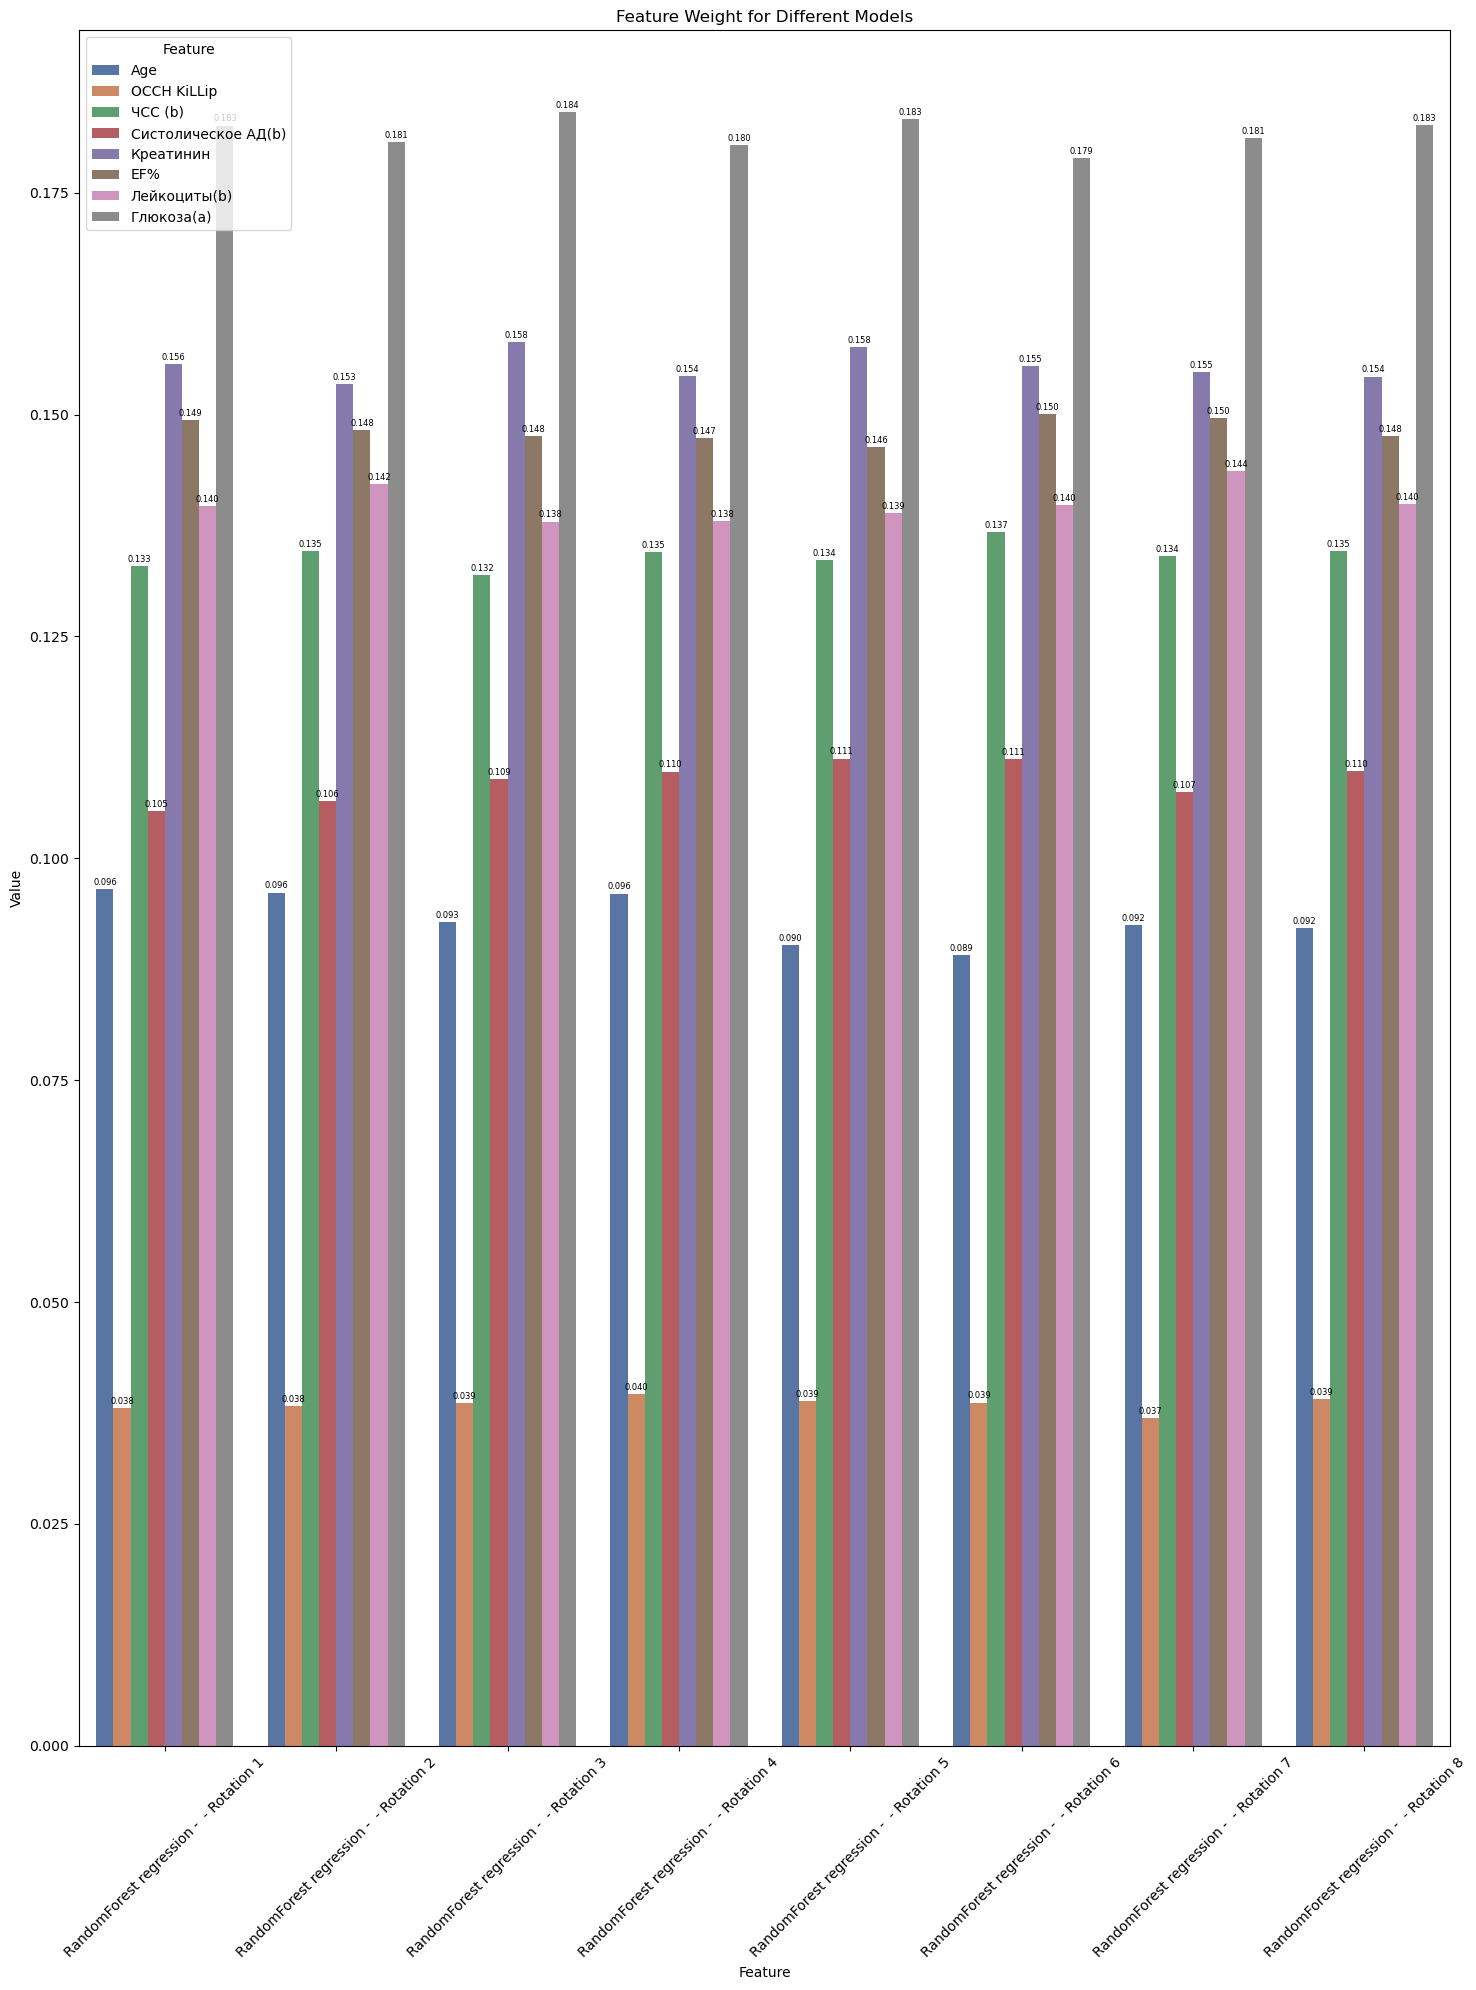

In [42]:
plot_values(flatten_df(forest_weights_shap_df), "Weight")

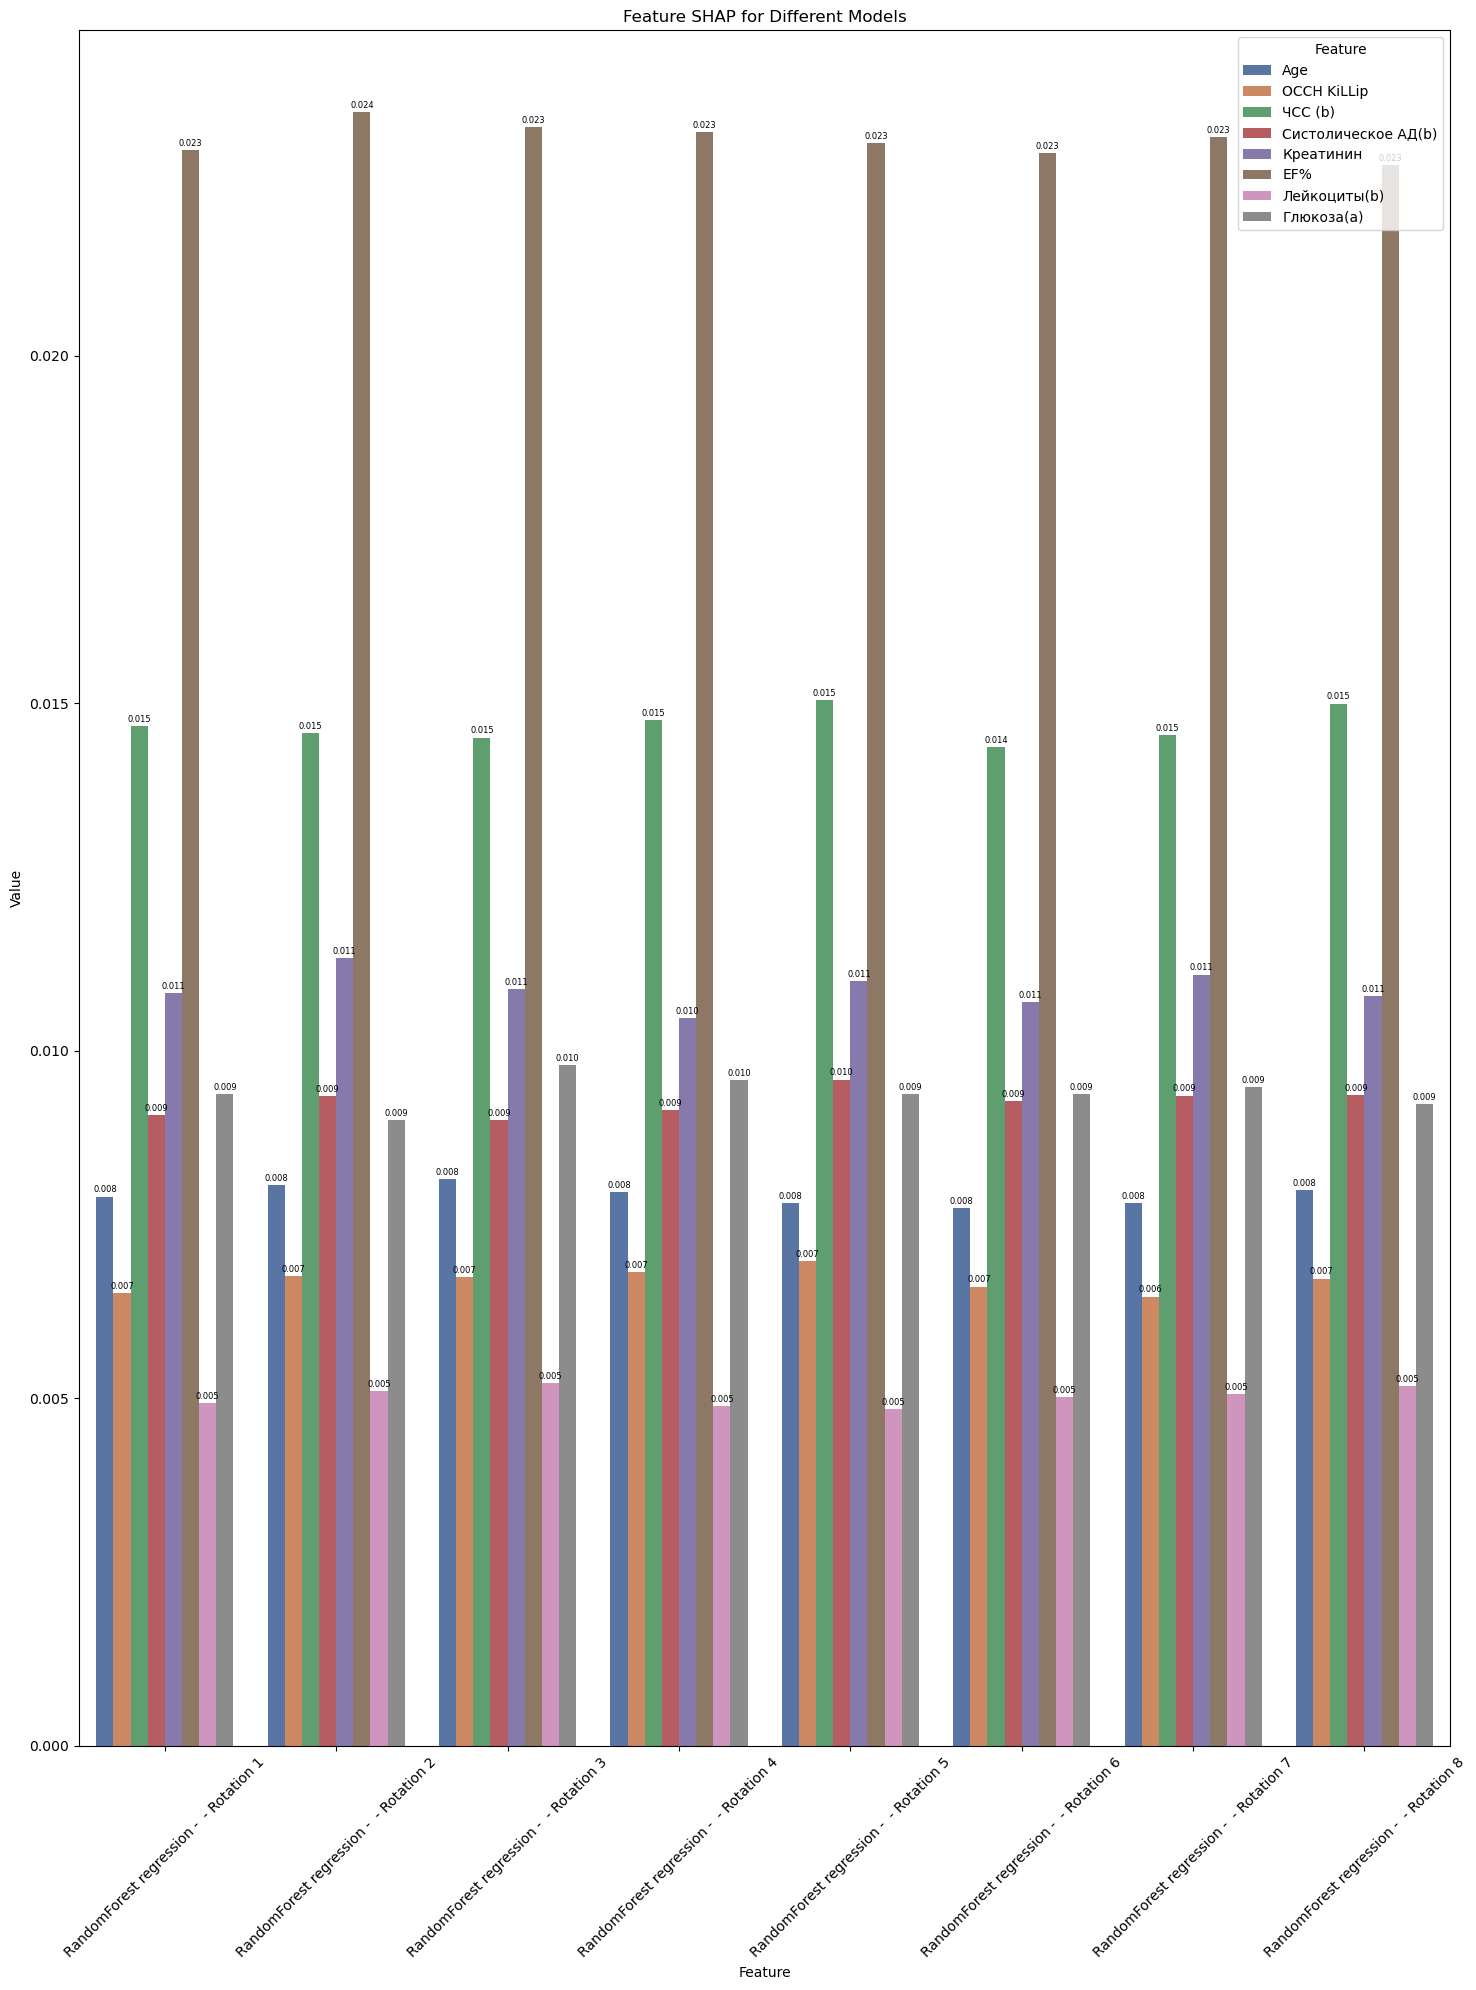

In [43]:
plot_values(flatten_df(forest_weights_shap_df), "SHAP")

In [44]:
combined_weights_tree_df = pd.concat([xgboost_weights_shap_df,
                                      forest_weights_shap_df
                                 ], axis=1)

In [45]:
display(combined_weights_tree_df.head(10))
display(combined_weights_tree_df.describe())

XGBoost regression -  - Rotation 1            \
                                                Weight      SHAP   
Age                                           0.079239  0.012124   
ОССН KiLLip                                   0.062564  0.007031   
ЧСС (b)                                       0.125158  0.018632   
Систолическое АД(b)                           0.153430  0.010451   
Креатинин                                     0.127759  0.013897   
EF%                                           0.163815  0.019597   
Лейкоциты(b)                                  0.138567  0.007425   
Глюкоза(a)                                    0.149467  0.013463   

                    XGBoost regression -  - Rotation 2            \
                                                Weight      SHAP   
Age                                           0.074692  0.009484   
ОССН KiLLip                                   0.061585  0.007974   
ЧСС (b)                                       0.134603  0.017461   
Систолическое АД(b)                           0.141384  0.012437   
Креатинин                                     0.116319  0.012877   
EF%                                           0.185749  0.024299   
Лейкоциты(b)                                  0.149640  0.009167   
Глюкоза(a)                                    0.136029  0.012559   

                    XGBoost regression -  - Rotation 3            \
                                                Weight      SHAP   
Age                                           0.074822  0.009992   
ОССН KiLLip                                   0.114193  0.007307   
ЧСС (b)                                       0.096868  0.016089   
Систолическое АД(b)                           0.137756  0.010753   
Креатинин                                     0.116888  0.014222   
EF%                                           0.159893  0.021713   
Лейкоциты(b)                                  0.140736  0.007769   
Глюкоза(a)                                    0.158844  0.014708   

                    XGBoost regression -  - Rotation 4            \
                                                Weight      SHAP   
Age                                           0.103944  0.009464   
ОССН KiLLip                                   0.106137  0.008629   
ЧСС (b)                                       0.108418  0.015755   
Систолическое АД(b)                           0.111630  0.009493   
Креатинин                                     0.114258  0.011940   
EF%                                           0.178203  0.022689   
Лейкоциты(b)                                  0.131054  0.008630   
Глюкоза(a)                                    0.146357  0.014952   

                    XGBoost regression -  - Rotation 5            ...  \
                                                Weight      SHAP  ...   
Age                                           0.090345  0.009602  ...   
ОССН KiLLip                                   0.096684  0.007203  ...   
ЧСС (b)                                       0.123133  0.016764  ...   
Систолическое АД(b)                           0.156134  0.010543  ...   
Креатинин                                     0.091854  0.011970  ...   
EF%                                           0.167521  0.021998  ...   
Лейкоциты(b)                                  0.134207  0.007131  ...   
Глюкоза(a)                                    0.140122  0.015406  ...   

                    RandomForest regression -  - Rotation 4            \
                                                     Weight      SHAP   
Age                                                0.096027  0.007970   
ОССН KiLLip                                        0.039632  0.006816   
ЧСС (b)                                            0.134524  0.014753   
Систолическое АД(b)                                0.109764  0.009141   
Креатинин                                          0.154357  0.010463   
EF%                                                0.1

XGBoost regression -  - Rotation 1            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012827   
std                             0.036051  0.004629   
min                             0.062564  0.007031   
25%                             0.113678  0.009694   
50%                             0.133163  0.012793   
75%                             0.150458  0.015081   
max                             0.163815  0.019597   

      XGBoost regression -  - Rotation 2            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.013282   
std                             0.040369  0.005342   
min                             0.061585  0.007974   
25%                             0.105912  0.009405   
50%                             0.135316  0.012498   
75%                             0.143448  0.014023   
max                             0.185749  0.024299   

      XGBoost regression -  - Rotation 3            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012819   
std                             0.029917  0.004833   
min                             0.074822  0.007307   
25%                             0.109862  0.009436   
50%                             0.127322  0.012487   
75%                             0.145263  0.015053   
max                             0.159893  0.021713   

      XGBoost regression -  - Rotation 4            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.012694   
std                             0.025889  0.004909   
min                             0.103944  0.008629   
25%                             0.107848  0.009255   
50%                             0.112944  0.010717   
75%                             0.134880  0.015152   
max                             0.178203  0.022689   

      XGBoost regression -  - Rotation 5            ...  \
                                  Weight      SHAP  ...   
count                           8.000000  8.000000  ...   
mean                            0.125000  0.012577  ...   
std                             0.029751  0.005157  ...   
min                             0.090345  0.007131  ...   
25%                             0.095477  0.009003  ...   
50%                             0.128670  0.011257  ...   
75%                             0.144125  0.015746  ...   
max                             0.167521  0.021998  ...   

      RandomForest regression -  - Rotation 4            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010852   
std                                  0.043169  0.005770   
min                                  0.039632  0.004882   
25%                                  0.106329  0.007681   
50%                                  0.136268  0.009359   
75%                                  0.149074  0.011535   
max                                  0.180370  0.023218   

      RandomForest regression -  - Rotation 5            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.010961   
std                                  0.044711  0.005740   
min                                  0.038876  0.004841   
25%                                  0.105985  0.007599   
50%                                  0.136255  0.009481   
75%                                  0.149107  0.012011   
max                                  0.183287  0.023056   

      RandomForest regression -  - Rotation 6            \
          

7. Deep Neural Network model

These calculations are time consuming, we will save models and explainers into folders.

In [46]:
from joblib import dump, load
import os
from tensorflow.keras.models import load_model

def save_object(obj, name, folder):
    """
    Save an object to a specified folder.
    
    Parameters
    ----------
    obj : object
        The object to save.
    name : str
        The name of the object.
    folder : str
        The folder to save the object in.
    """
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, name)
    
    if isinstance(obj, tf.keras.models.Model):
        obj.save(path)
        print(f"Keras model saved to {path}")
    else:
        dump(obj, path + '.joblib')
        print(f"Object saved to {path}.joblib")

def load_object(name, folder):
    """
    Load an object from a specified folder.
    
    Parameters
    ----------
    name : str
        The name of the object.
    folder : str
        The folder to load the object from.
    
    Returns
    -------
    object
        The loaded object.
    """
    path = os.path.join(folder, name)
    
    if os.path.exists(path):
        obj = load_model(path)
        print(f"Keras model loaded from {path}")
    elif os.path.exists(path + '.joblib'):
        obj = load(path + '.joblib')
        print(f"Object loaded from {path}.joblib")
    else:
        print(f"No object found at {path} or {path}.joblib")
        obj = None
    
    return obj

def get_or_create_object(create_func, name, folder, *args, **kwargs):
    """
    Get an object from a specified folder, or create it if it doesn't exist.
    
    Parameters
    ----------
    create_func : callable
        A function that creates the object.
    name : str
        The name of the object.
    folder : str
        The folder to get the object from.
    *args
        Positional arguments to pass to create_func.
    **kwargs
        Keyword arguments to pass to create_func.
    
    Returns
    -------
    object
        The object.
    """
    # Try to load the object
    obj = load_object(name, folder)
    
    # If the object doesn't exist, create it
    if obj is None:
        obj = create_func(*args, **kwargs)
        save_object(obj, name, folder)
    
    return obj

In [47]:
X_train.shape


(2419, 8)

In [48]:
def create_keras_model():
    # Define model architecture
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)
    return model

In [49]:
keras_seq_model = get_or_create_object(create_keras_model, 'Keras_Sequential_v1', 'export/models')

Keras model loaded from export/models\Keras_Sequential_v1


In [50]:
def get_kernel_shap_values(model):
    explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100))  
    X_test_reset = shap.sample(X_test.reset_index(drop=True), 10)
    shap_values = explainer.shap_values(X_test_reset.values, l1_reg='aic') 
    return shap_values

# No errors, but values are zeros
kernel_shap_values = get_or_create_object(get_kernel_shap_values, 'kernel_shap_values_v1', 'export/shap_values', model=keras_seq_model)

Object loaded from export/shap_values\kernel_shap_values_v1.joblib


In [51]:
def get_partition_shap_values(model):
    explainer = shap.PartitionExplainer(model.predict, shap.sample(X_train, 100))
    shap_values = explainer(shap.sample(X_test, 100)) 
    return shap_values

partition_shap_values = get_or_create_object(get_partition_shap_values, 'partition_shap_values_v1', 'export/shap_values', model=keras_seq_model)

Object loaded from export/shap_values\partition_shap_values_v1.joblib


In [52]:
def get_permutations_shap_values(model):
    explainer = shap.PermutationExplainer(keras_seq_model.predict, X_train)
    shap_values = explainer(X_test)
    return shap_values

In [53]:
per_shap_values = get_or_create_object(get_permutations_shap_values, 'permutation_shap_values_v1', 'export/shap_values', model=keras_seq_model)


Object loaded from export/shap_values\permutation_shap_values_v1.joblib


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


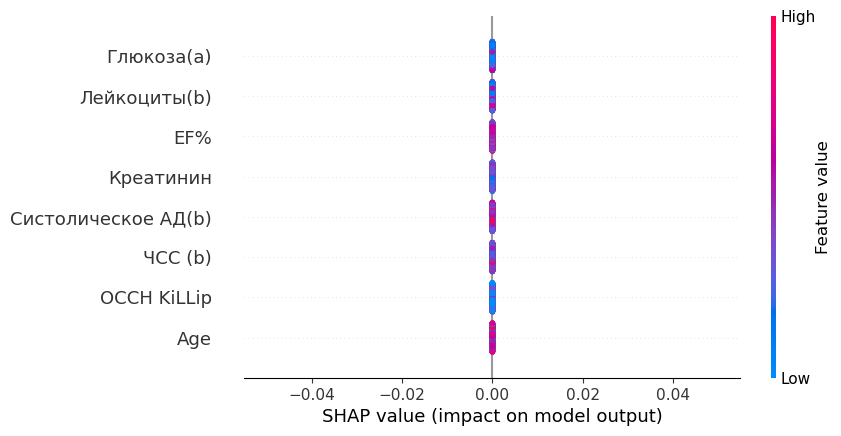

In [54]:
shap.plots.beeswarm(per_shap_values)

In [55]:
mean_abs_shap_values = np.abs(per_shap_values.values).mean(axis=0)

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame(mean_abs_shap_values, index=X_train.columns, columns=["SHAP Values"])
#feature_importances.sort_values(by="SHAP Values", ascending=False, inplace=True)

display(feature_importances)

,SHAP Values
Age,0.0
ОССН KiLLip,0.0
ЧСС (b),0.0
Систолическое АД(b),0.0
Креатинин,0.0
EF%,0.0
Лейкоциты(b),0.0
Глюкоза(a),0.0


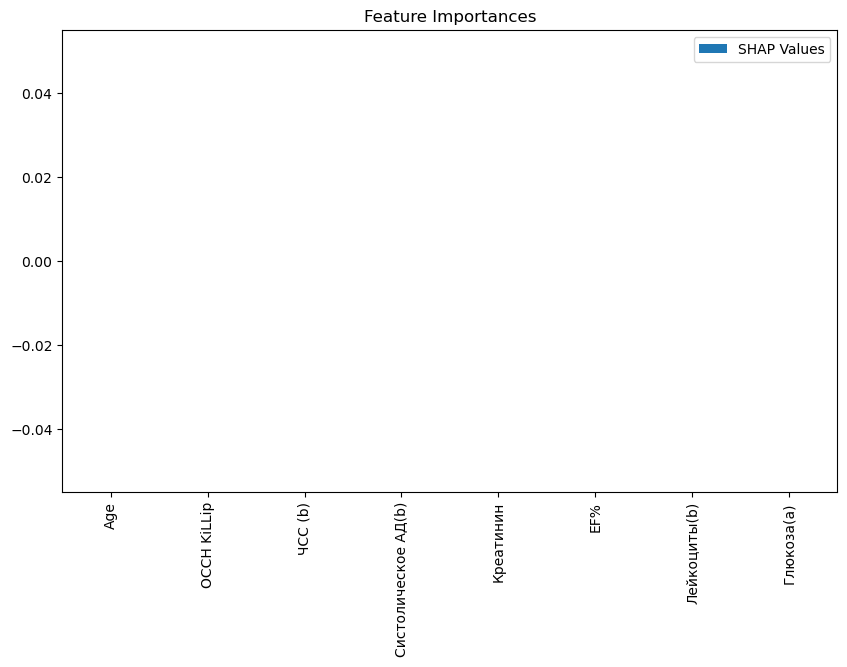

In [56]:
# Plot the feature importances
feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()